In [ ]:
# -*- coding: utf-8 -*-
"""
Created on 10/01, 2022
@author: Willy Fang
"""

# Import Libraries

In [3]:
import pandas as pd
import numpy as np
from glob import glob
import math
import os
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 1000)
import cv2
import pytesseract
from pdf2image import convert_from_path  # Faster way if using Anaconda: conda install -c conda-forge poppler
# import PyPDF2
# from PyPDF2 import PdfFileReader
# from PIL import Image
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings("ignore")
# pytesseract.pytesseract.tesseract_cmd = r'\Tesseract-OCR\tesseract.exe'
pytesseract.pytesseract.tesseract_cmd = r'D:\Tesseract-OCR\tesseract.exe'

# Convert PDFs to Images (JPGs)

In [97]:
for pdf_file in glob("*.pdf"):
    folder_name = pdf_file.split(".")[0]
    if not os.path.isdir(folder_name):
        os.mkdir(folder_name)

    print("Converting "+pdf_file+"......")
    pages = convert_from_path(pdf_file, dpi=400)
    print("Converting "+pdf_file+" Done!")
    
    print("Saving Images of "+pdf_file+"......")
    for ind, page in enumerate(pages):
        page.save(folder_name+'/Page_'+str(ind+1)+'.jpg', 'JPEG')
    print("Saving Images of "+pdf_file+" Done!")
    print()

Converting Certificate of Degree.pdf......
Converting Certificate of Degree.pdf Done!
Saving Images of Certificate of Degree.pdf......
Saving Images of Certificate of Degree.pdf Done!

Converting Certificate of Degree_Marked.pdf......
Converting Certificate of Degree_Marked.pdf Done!
Saving Images of Certificate of Degree_Marked.pdf......
Saving Images of Certificate of Degree_Marked.pdf Done!

Converting Transcripts.pdf......
Converting Transcripts.pdf Done!
Saving Images of Transcripts.pdf......
Saving Images of Transcripts.pdf Done!



# Text Recognition V01

In [10]:
# ### Pre-Processing
# # def get_cv2_img1(img_path):
# #     img = cv2.imread(img_path)
# #     gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # COLOR_BGR2GRAY、COLOR_BGR2HSV
# #     img_blur = cv2.GaussianBlur(gray, (3,3), 0)
# #     _,thresh = cv2.threshold(img_blur, 200, 255, cv2.THRESH_BINARY_INV)
# #     return [img, gray, img_blur, thresh]

# ### Pre-Processing
# def get_cv2_img1(img_path):
#     img = cv2.imdecode(np.fromfile(img_path,dtype=np.uint8),-1)[100:1700, 50:2550-50]
#     img_gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY) # COLOR_BGR2GRAY
#     return img_gray

# ### Text Data Processing
# def remove_space(x):
#     if x.strip() == "" or x.strip() == "nan":
#         return np.nan
#     else:
#         return x

# ### Read Text from Image
# def image_recognition1(img_path):
#     text = pytesseract.image_to_data(get_cv2_img1(img_path), lang='eng', output_type="data.frame")
#     text["text"] = text["text"].astype(str).apply(lambda x: remove_space(x))
#     text = text.dropna(how="any").reset_index(drop=True)
#     text["text"] = text["text"].apply(lambda x: x.replace(",","").replace(":",""))
#     return text

In [11]:
# for i in [1, 2, 3, 4]:
#     if not os.path.isdir('kickoff_'+str(i)+"_Edit/JPG/Converted"):
#         os.mkdir('kickoff_'+str(i)+"_Edit/JPG/Converted")
#     print("Image recognition "+str(i)+"......")
#     for image_path in glob('kickoff_'+str(i)+"_Edit/JPG/*.jpg"):
#         image_recog_df = image_recognition1(image_path)
#         df_name = image_path.split(".")[0].split("\\")[-1]
#         image_recog_df.to_excel('kickoff_'+str(i)+"_Edit/JPG/Converted/"+df_name+".xlsx", index=False)
#     print("Image recognition "+str(i)+" Done!")

# Text Recognition V02

In [112]:
### Image Pre-Processing: Load & Transform Images
def get_cv2_img2(img_path, method_num=1):
#     img = cv2.imdecode(np.fromfile(img_path, dtype=np.uint8),-1)[100:1700, 50:2550-50]
    img = cv2.imread(img_path)
    if method_num == 0: # Method 0: Original Image
        return img
    
    img_gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    if method_num == 1: # Method 1: Gray Scaling
        return img_gray
    
    elif method_num == 2: # Method 2: Gray Scaling & Binary Thresholding
        ret, img_gray = cv2.threshold(img_gray, 127, 255, cv2.THRESH_BINARY)
        return img_gray
    
    elif method_num == 3: # Method 3: Gray Scaling & Inverse Binary Thresholding
        ret, img_gray = cv2.threshold(img_gray, 127, 255, cv2.THRESH_BINARY_INV)
        return img_gray
    
    elif method_num == 4: # Method 4: Gray Scaling & Increase brightness & Increase Contrast (Adjust 1)
        img_gray = modify_contrast_and_brightness1(img_gray, brightness=45, contrast=35)
        return img_gray
    
    elif method_num == 5: # Method 5: Gray Scaling & Increase brightness & Increase Contrast (Adjust 2)
        img_gray = modify_contrast_and_brightness1(img_gray, brightness=25, contrast=50)
        return img_gray

    elif method_num == 6: # Method 6: Gray Scaling & Reduce brightness & Increase Contrast (Adjust 1)
        img_gray = modify_contrast_and_brightness1(img_gray, brightness=-35, contrast=60)
        return img_gray

    elif method_num == 7: # Method 7: Gray Scaling & Reduce brightness & Increase Contrast (Adjust 1) + Binary Thresholding
        img_gray = modify_contrast_and_brightness1(img_gray, brightness=-35, contrast=60)
        ret, img_gray = cv2.threshold(img_gray, 127, 255, cv2.THRESH_BINARY)
        return img_gray


### Image Pre-Processing: Modify Contrast and Brightness of Images (if necessary)
def modify_contrast_and_brightness1(img, brightness=25, contrast=25):
#     brightness = +25  # + Increase Brightness / - Reduce Brightness
#     contrast = +25  # + Increase Contrast / - Reduce Contrast
    B = brightness / 255.0
    c = contrast / 255.0 
    k = math.tan((45 + 44 * c) / 180 * math.pi)
    img = (img - 127.5 * (1 - B)) * k + 127.5 * (1 + B)
#     The values have to be in range 0~255. If values>255 then values=255, If values<0 then values=0
    img = np.clip(img, 0, 255).astype(np.uint8)
    return img


def remove_space(x):
    if x.strip() == "":
        return np.nan
    else:
        return x


### Text Recognition: Read Text and Process Data
def text_recognition2(img_path, n=1):
    text = pytesseract.image_to_data(get_cv2_img2(img_path, method_num=n), lang="eng+chi_tra", output_type="data.frame")
    text["text"] = text["text"].astype(str).apply(lambda x: remove_space(x))
    text = text.dropna(how="any")
#     text["text"] = text["text"].apply(lambda x: x.replace(",","").replace(":","").strip("_").strip("—"))
    text = text[text["text"]!=""]
    text = text[text["conf"]!=-1]
    text = text[text["text"]!="|"].reset_index(drop=True)
    return text.drop_duplicates(keep='last')


# def text_recognition_data_transform1(text):
#     return text.drop_duplicates(keep='last')


def text_recognition_data_to_txt1(text):
    text_string = ""
    for i in set(text["block_num"]):
        for j in set(text["line_num"]):
            if len(text[(text["block_num"]==i) & (text["line_num"]==j)]) == 0:
                continue
            text_string += text[(text["block_num"]==i) & 
                                (text["line_num"]==j)]["text"].str.cat(sep=' ') + "\n\n"
    return text_string.strip()


# def text_recognition_choose_best1(text_list):
#     text_list = [text for text in text_list if len(text)!=0]
#     best_conf = -0.0001
#     best_text = pd.DataFrame()
#     for text in text_list:
#         text_conf = np.mean(text[(text["width"]>200) & (text["width"]<350)]["conf"])
#         if text_conf>best_conf:
#             best_conf = text_conf
#             best_text = text
#     if len(best_text)==0:
#         for text in text_list:
#             text_conf = np.mean(text[(text["width"]>150) & (text["width"]<350)]["conf"])
#             if text_conf>best_conf:
#                 best_conf = text_conf
#                 best_text = text
#     return best_text

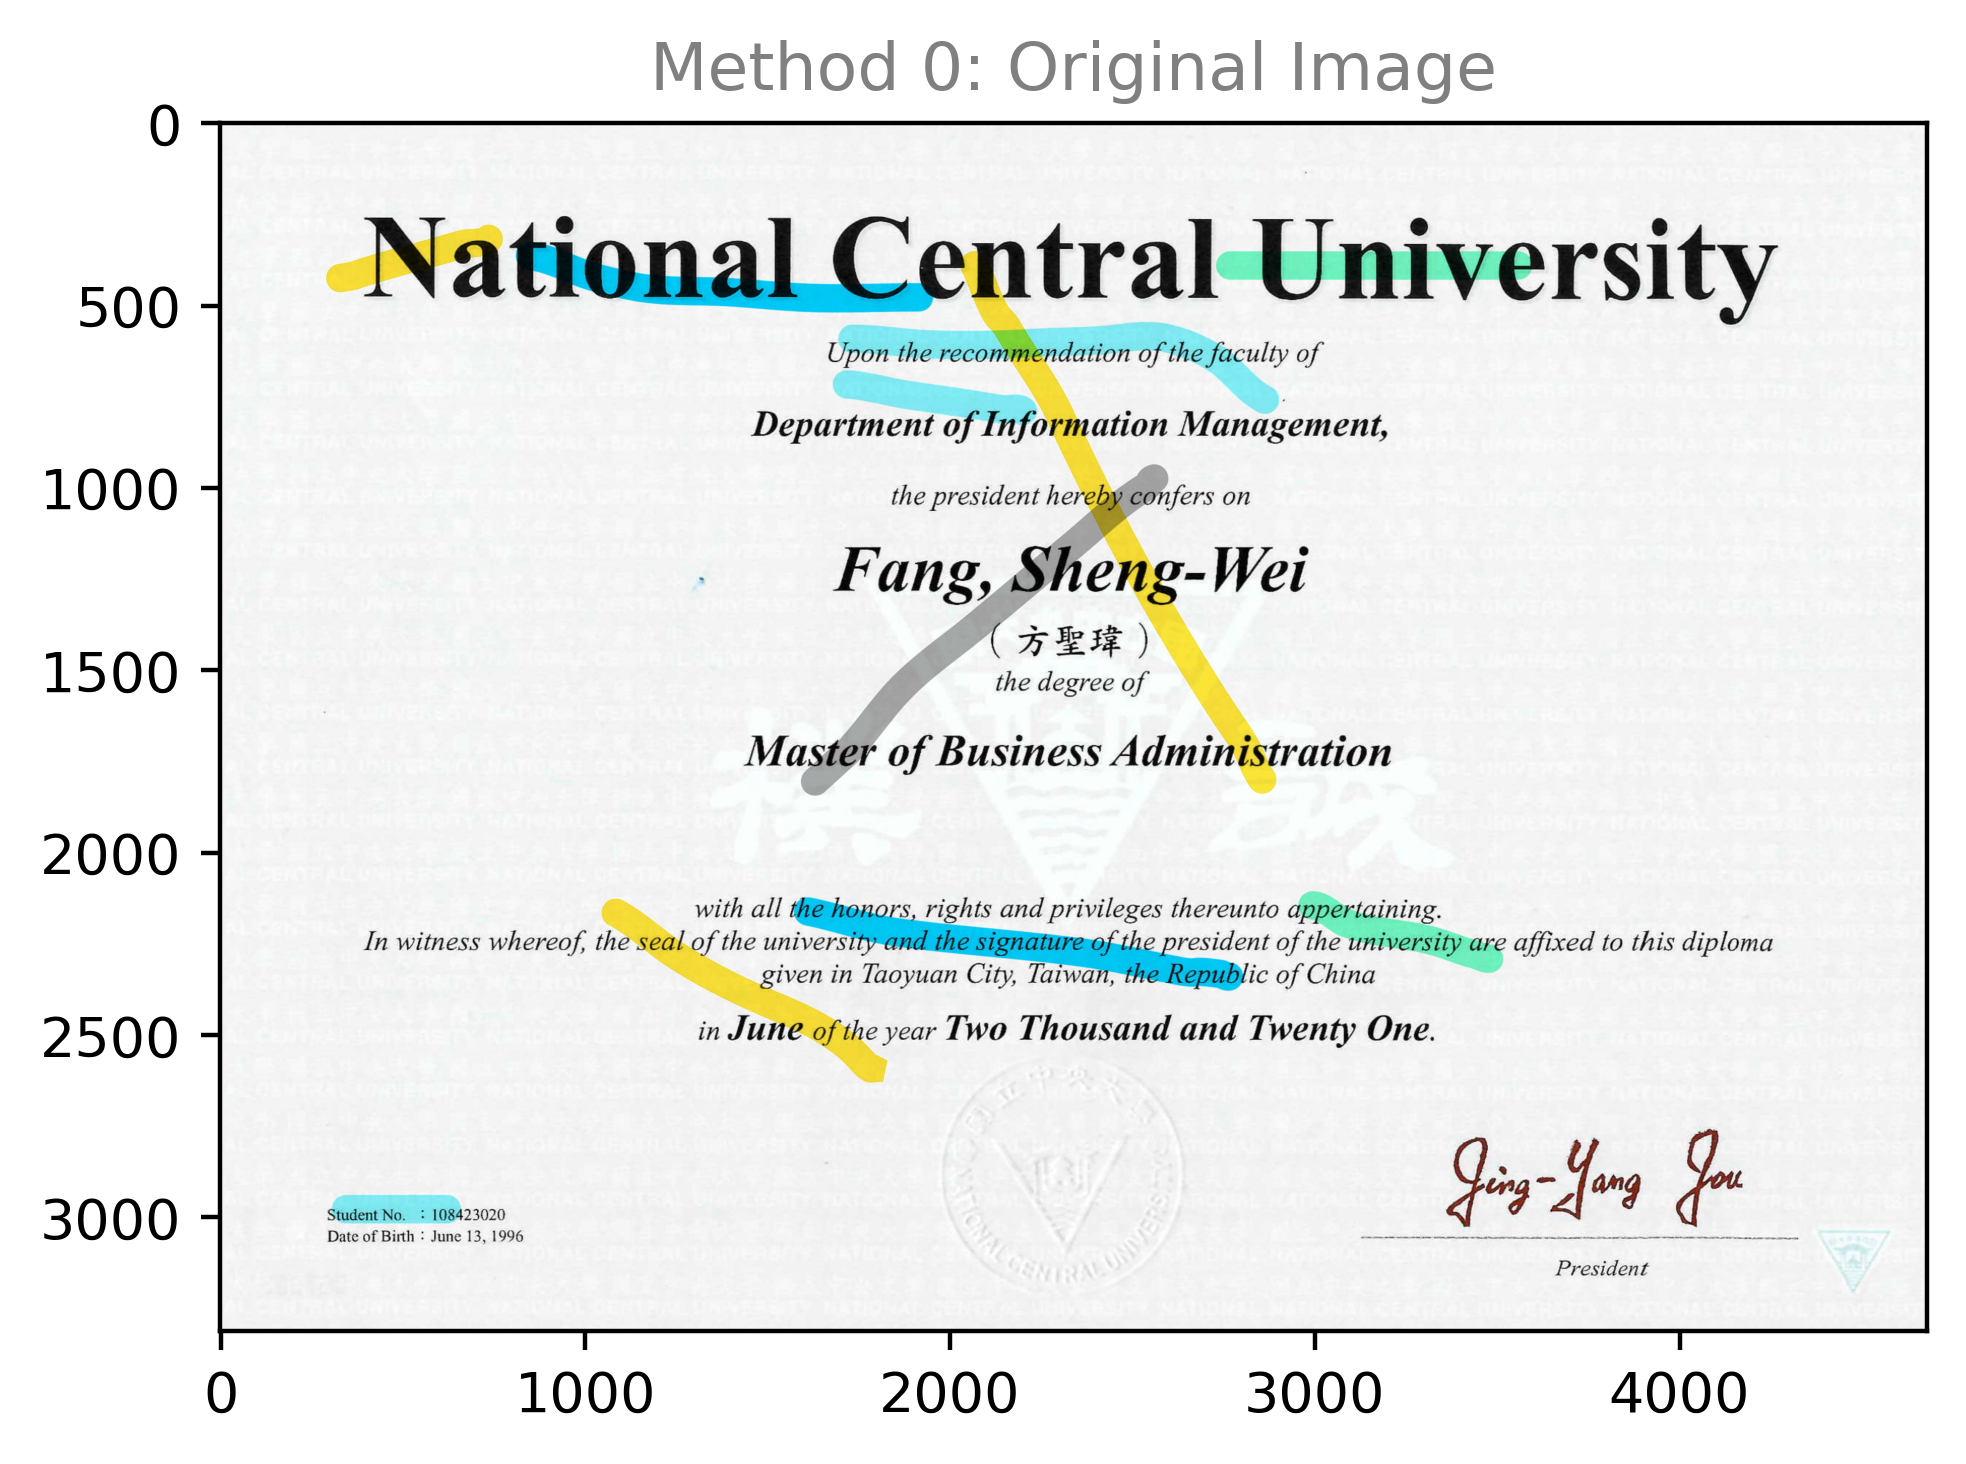

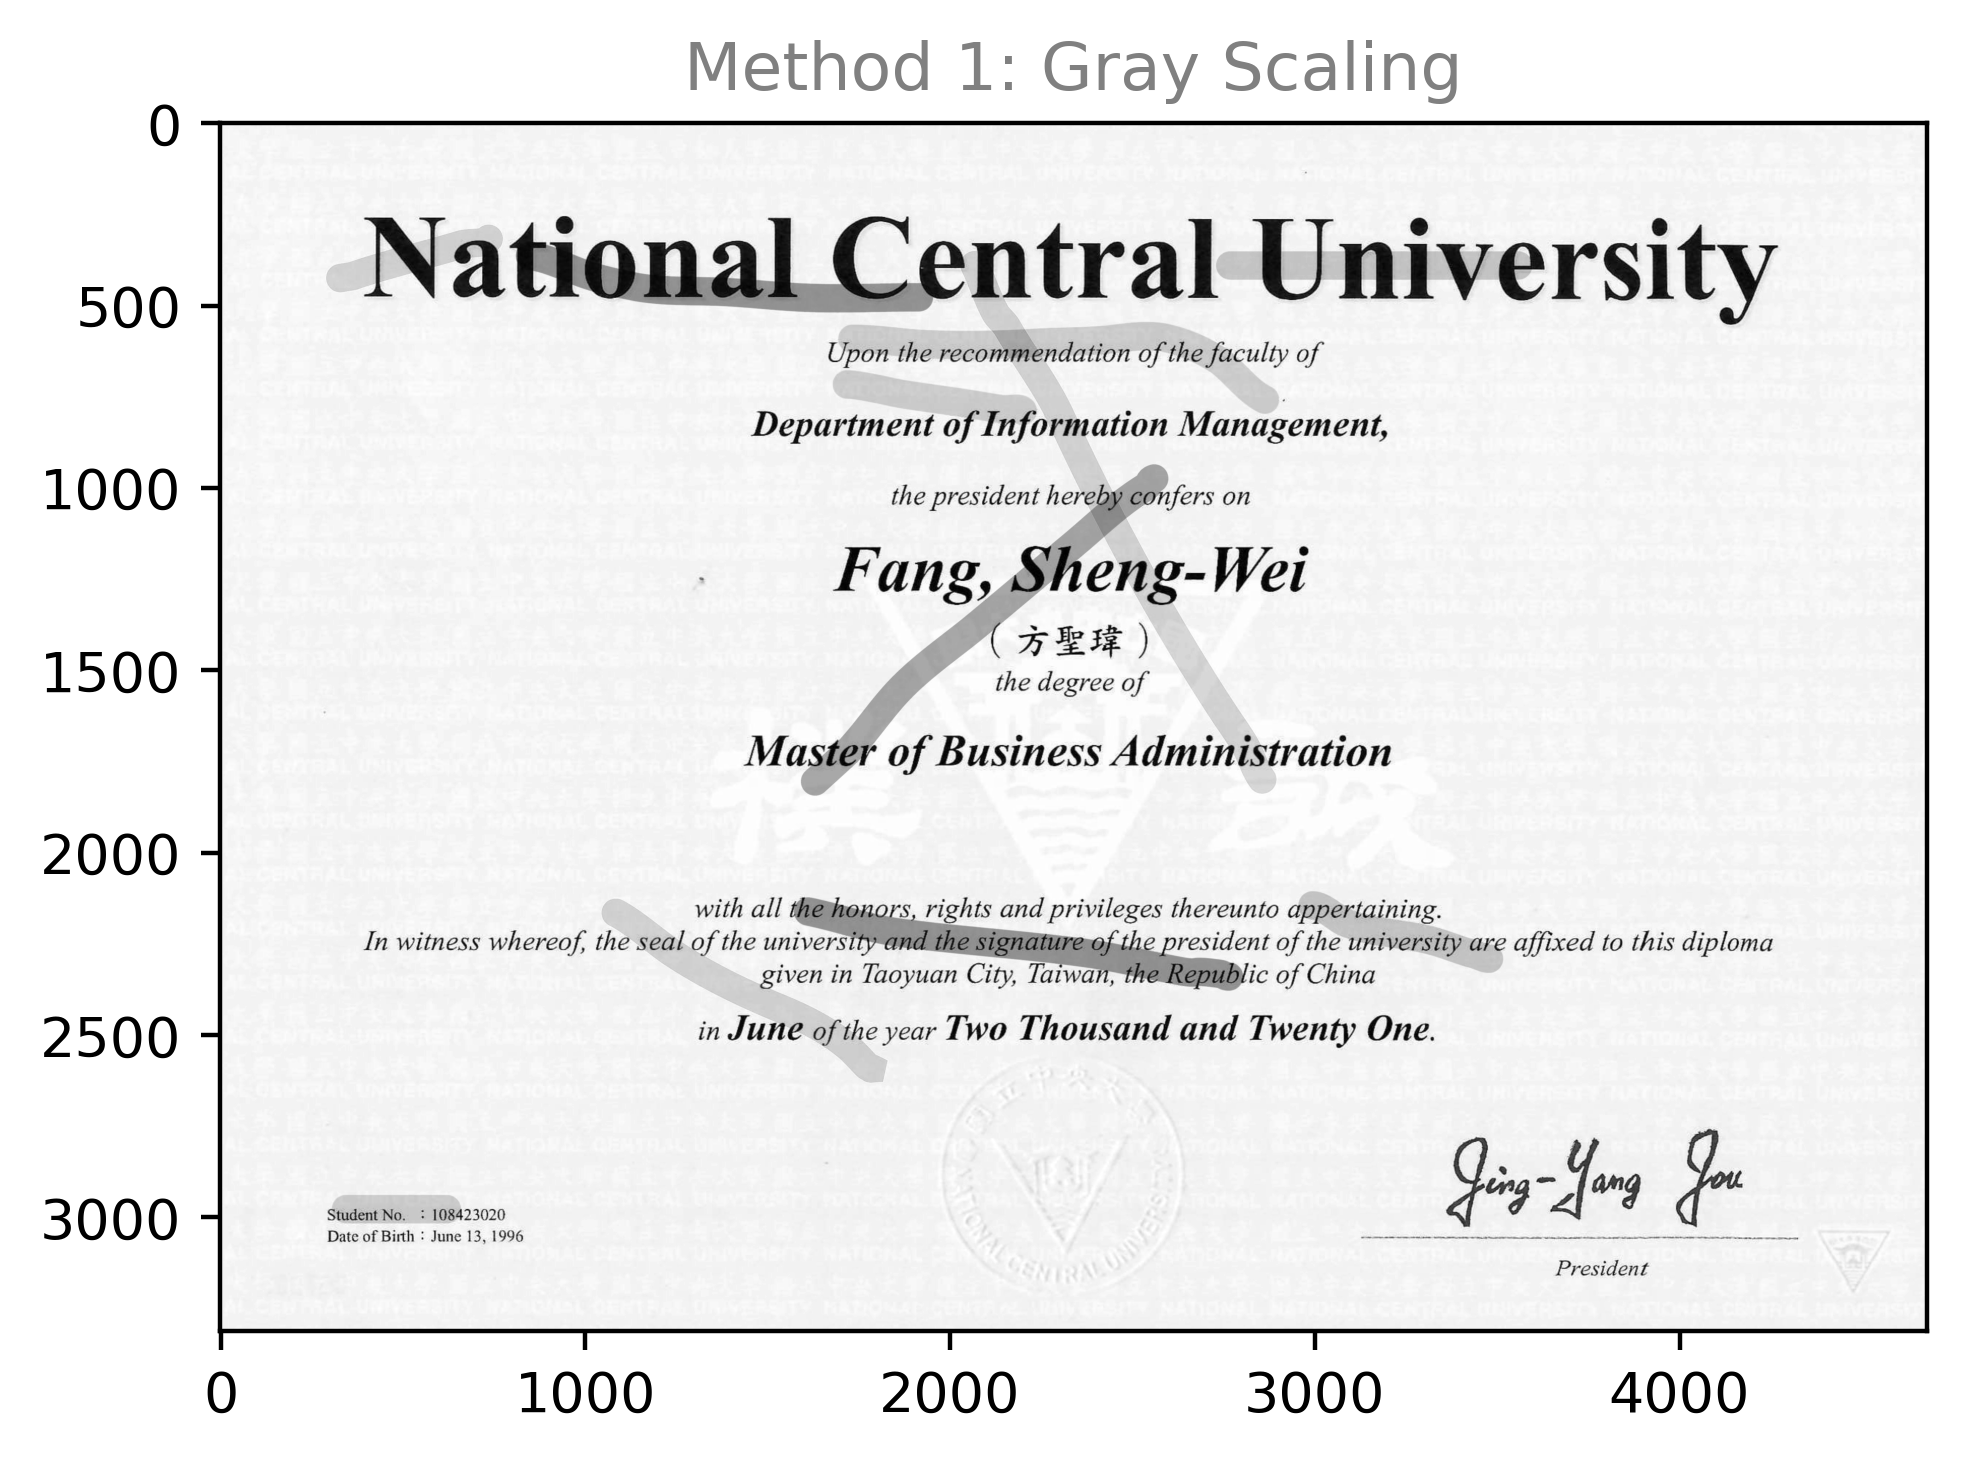

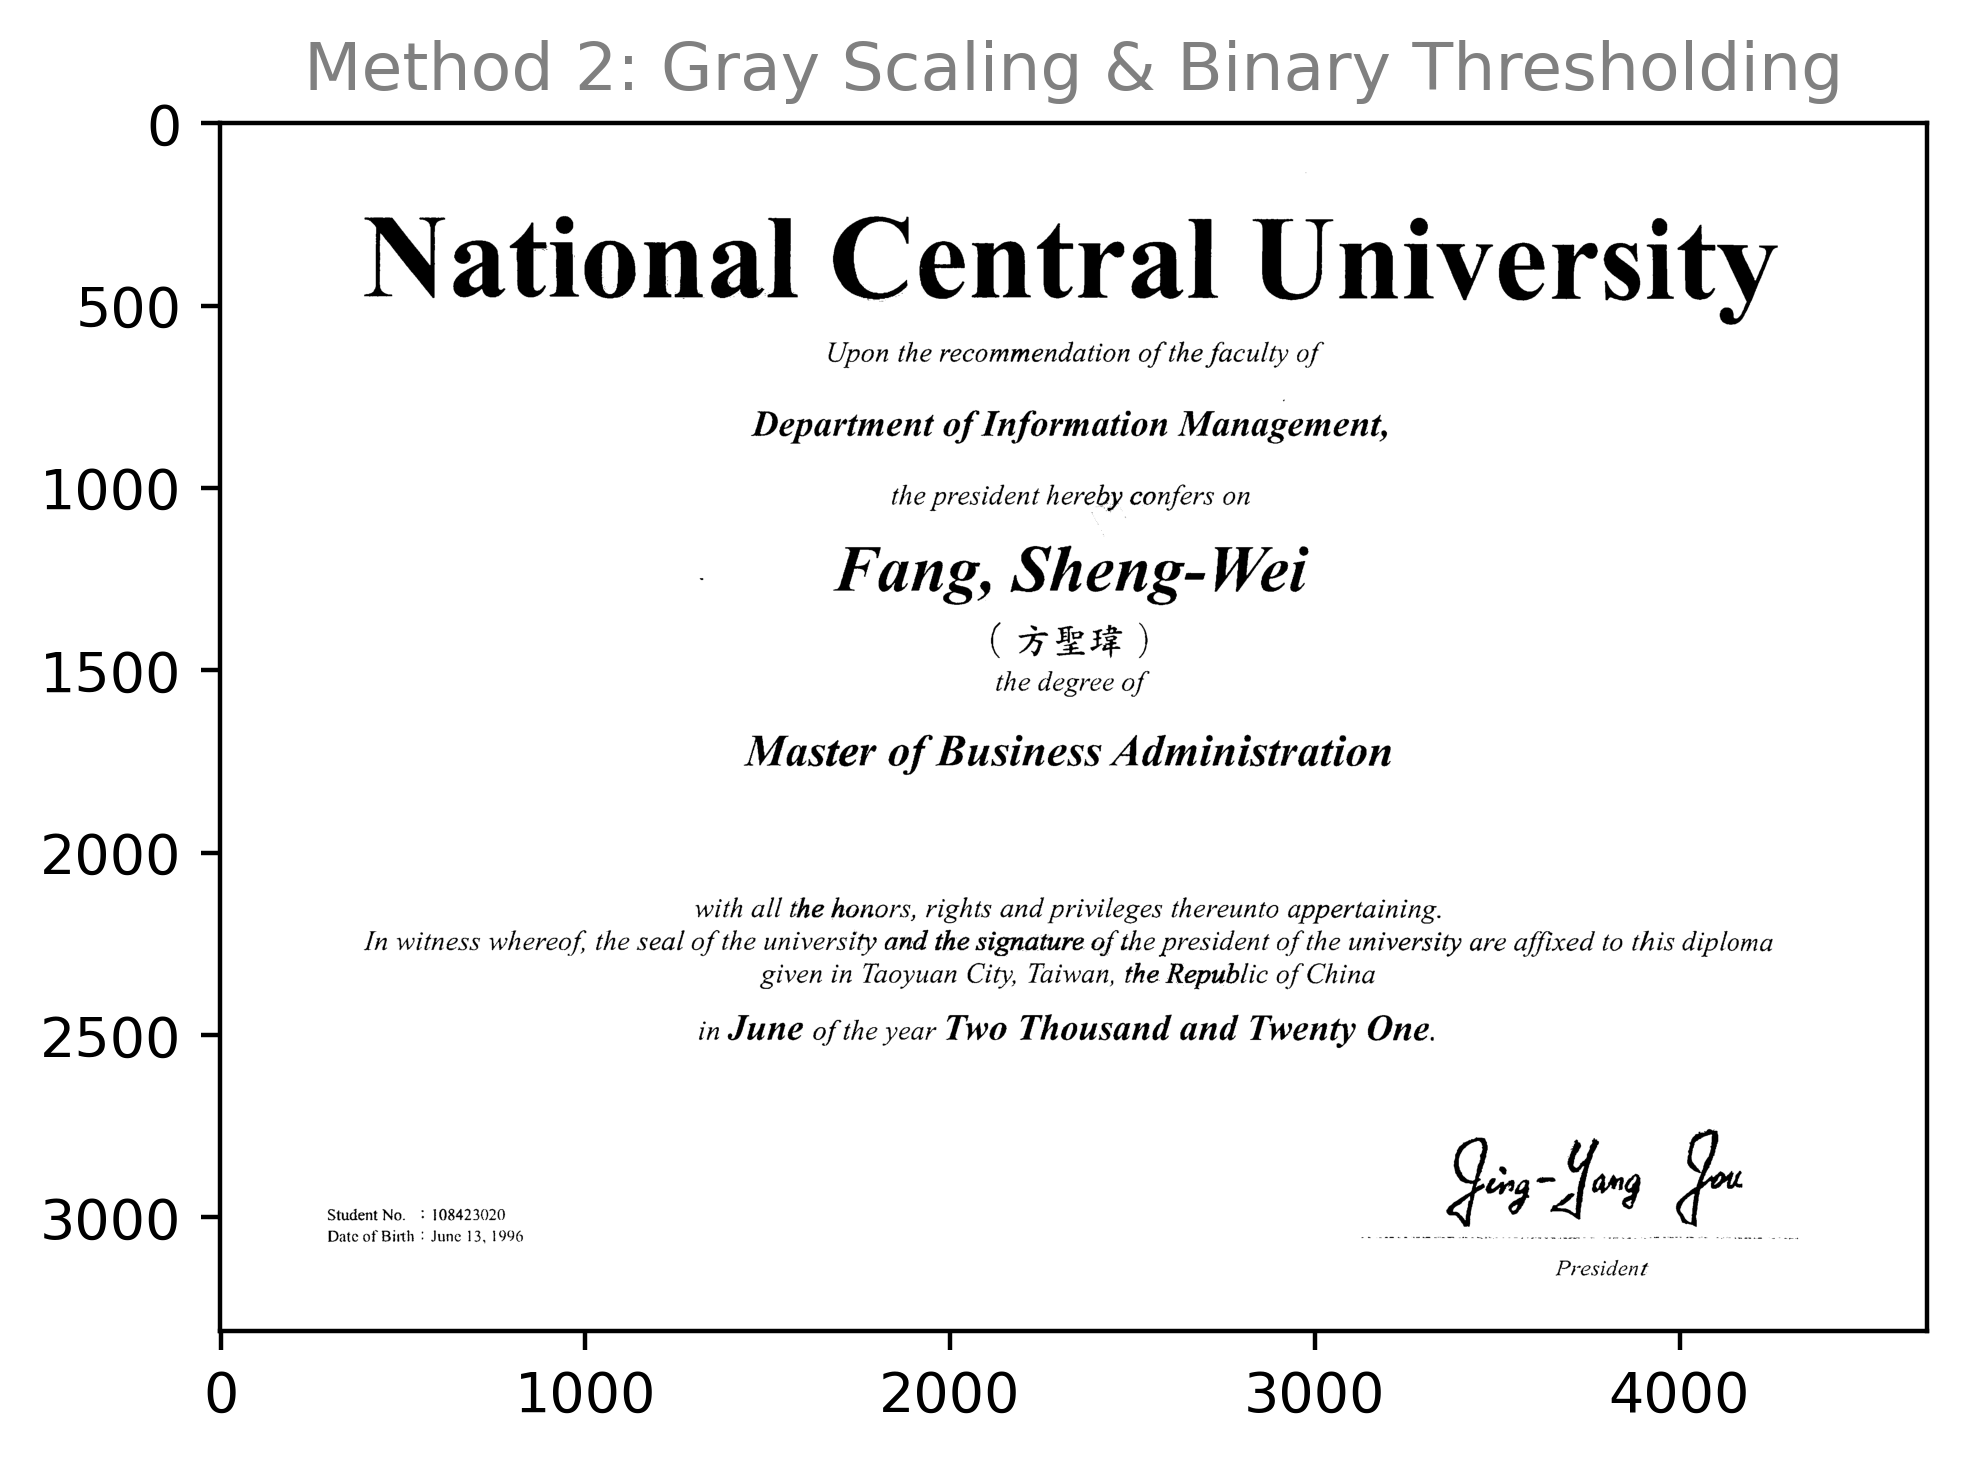

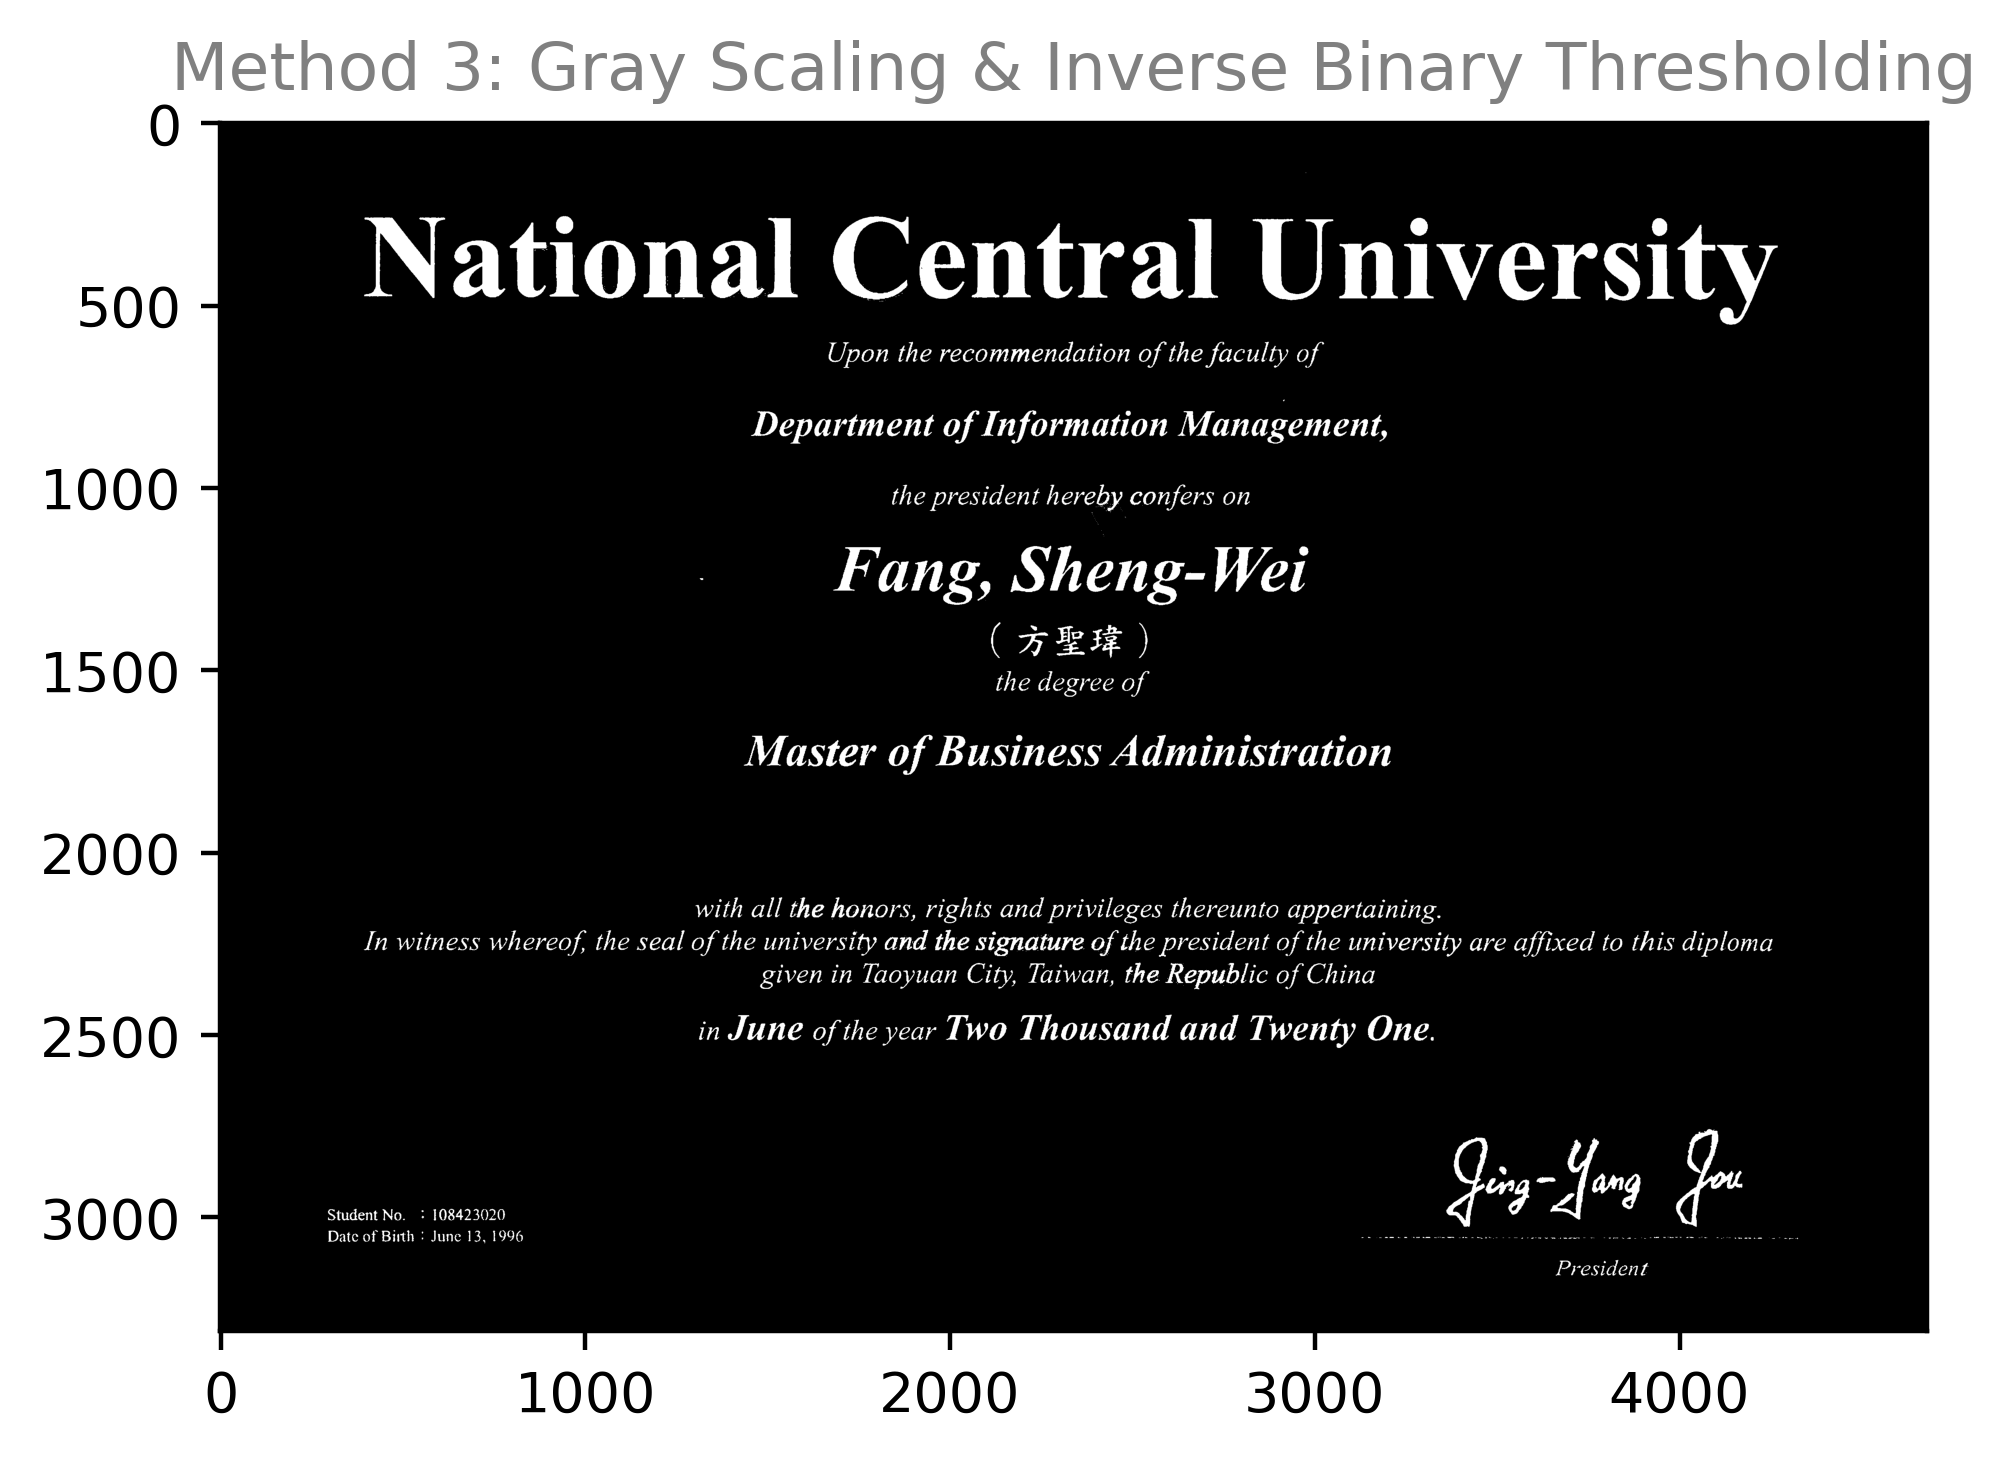

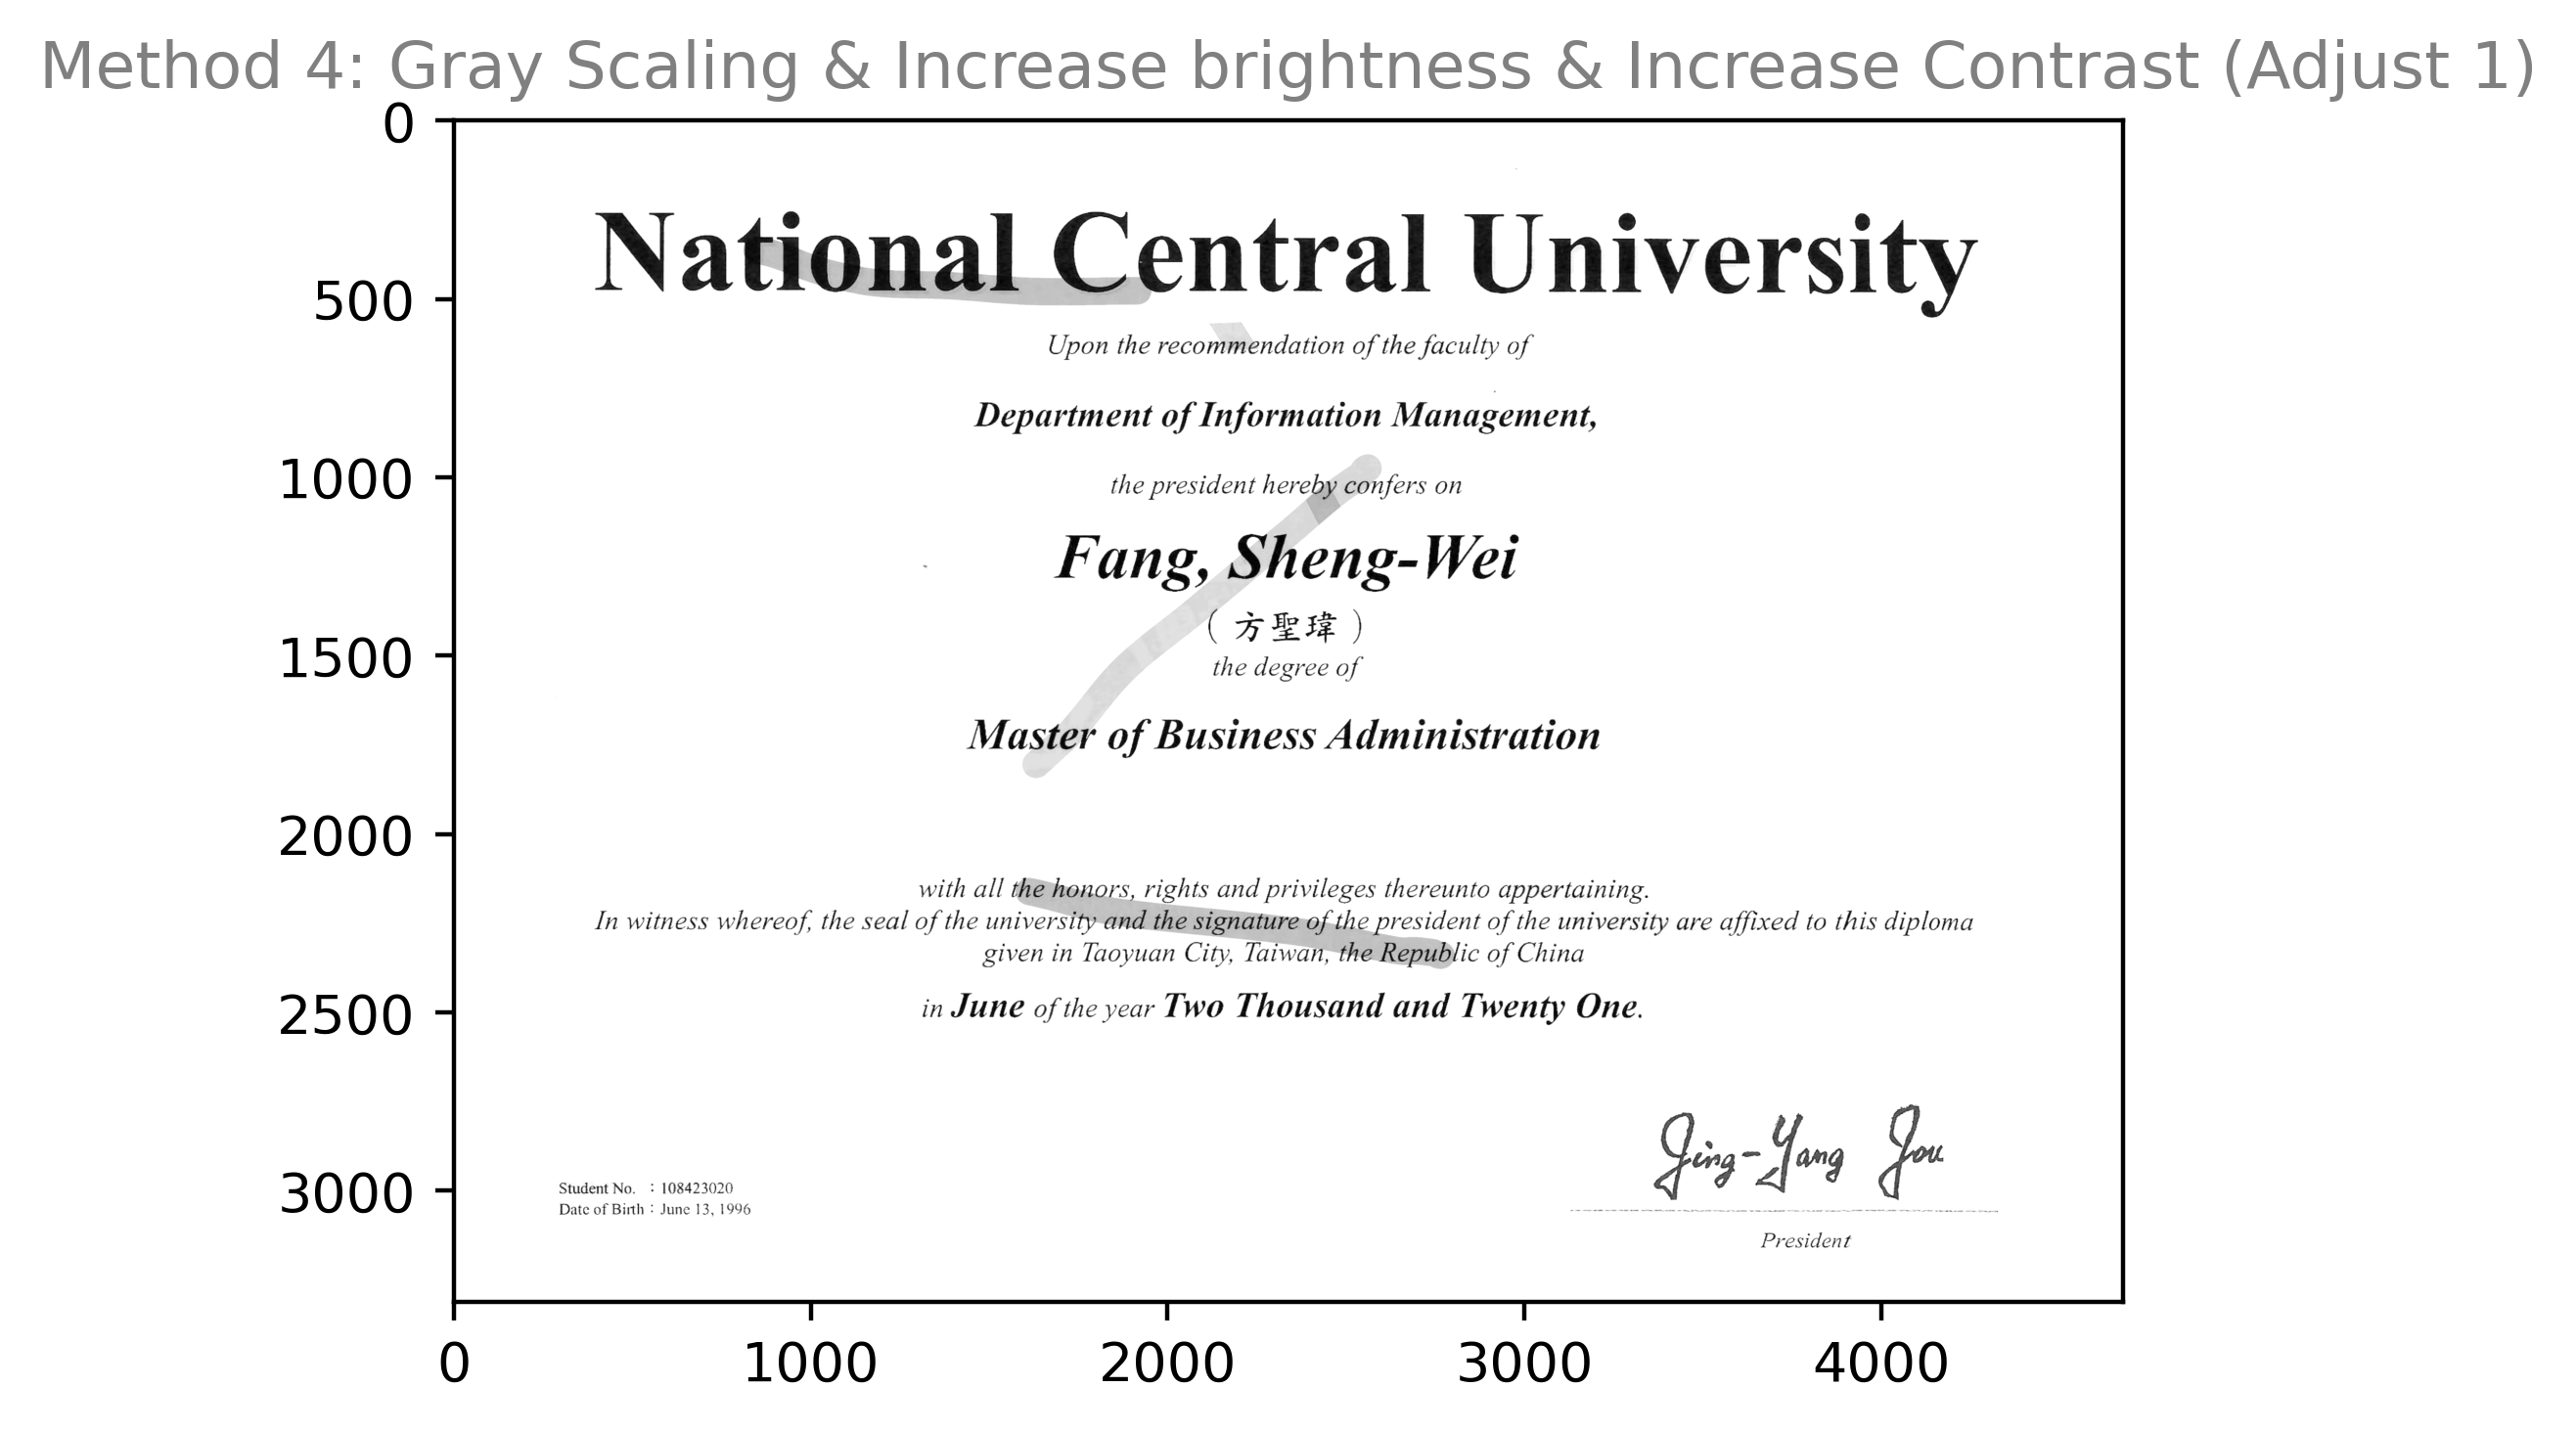

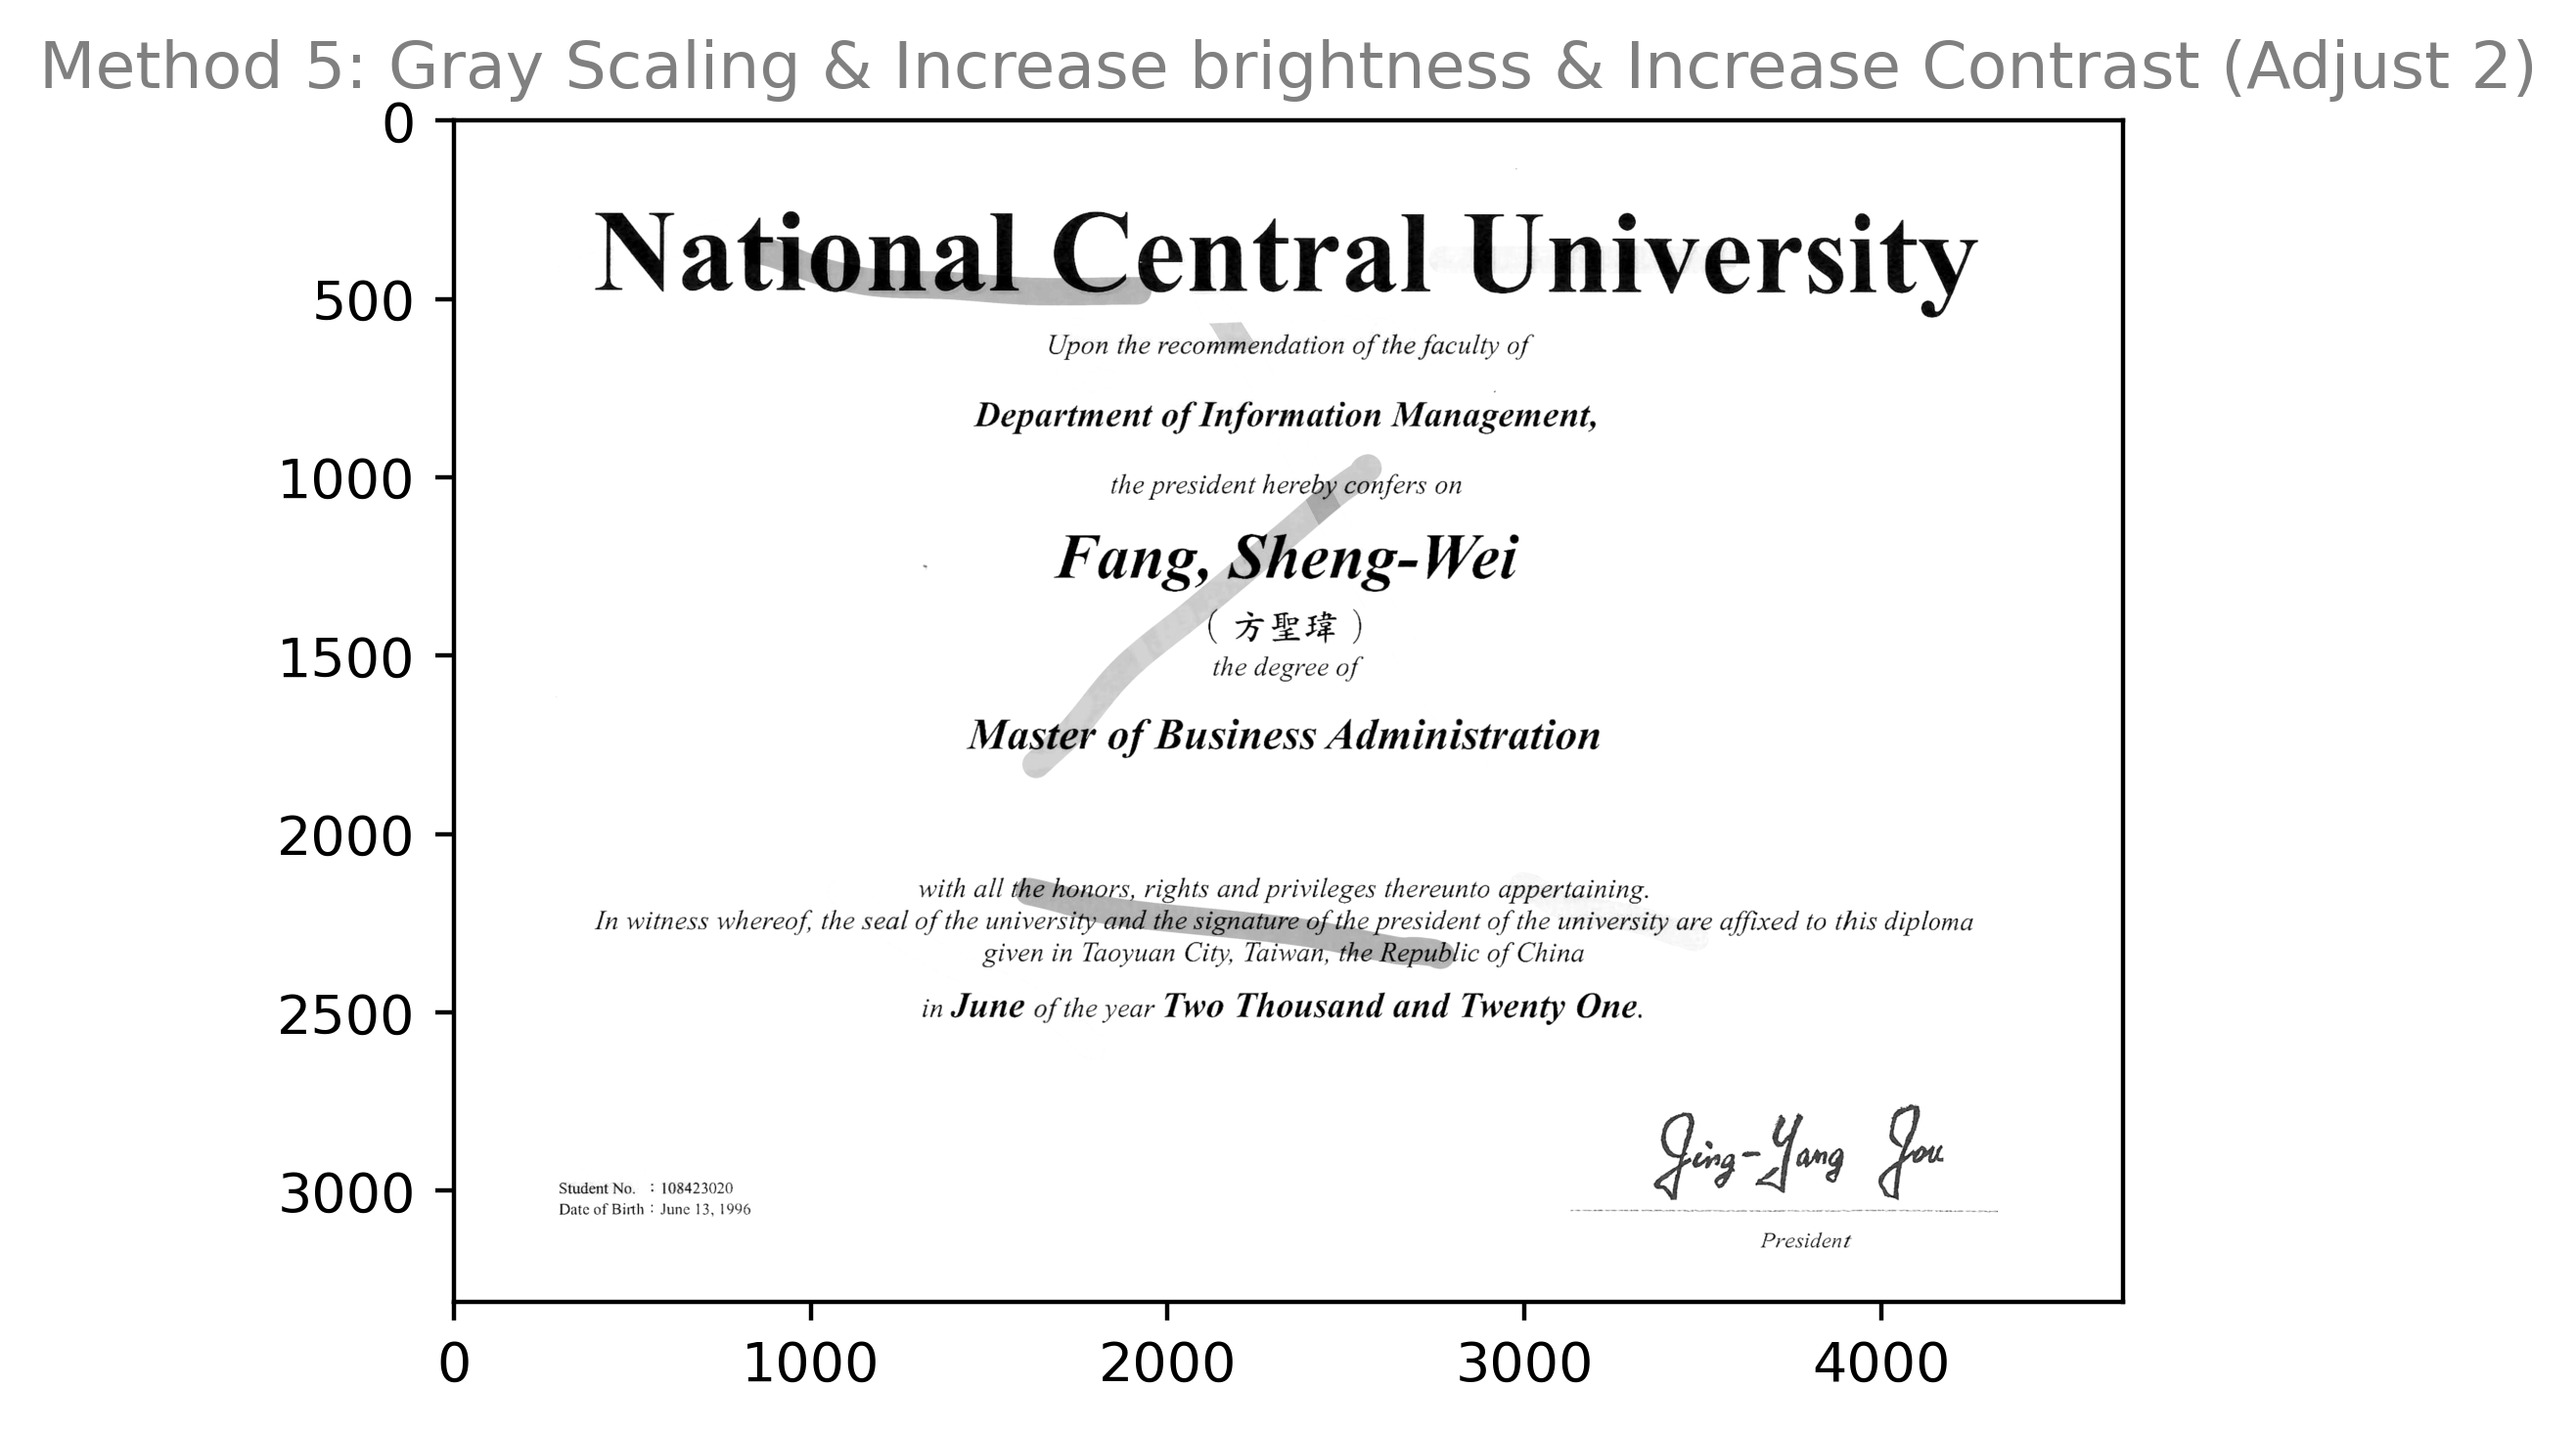

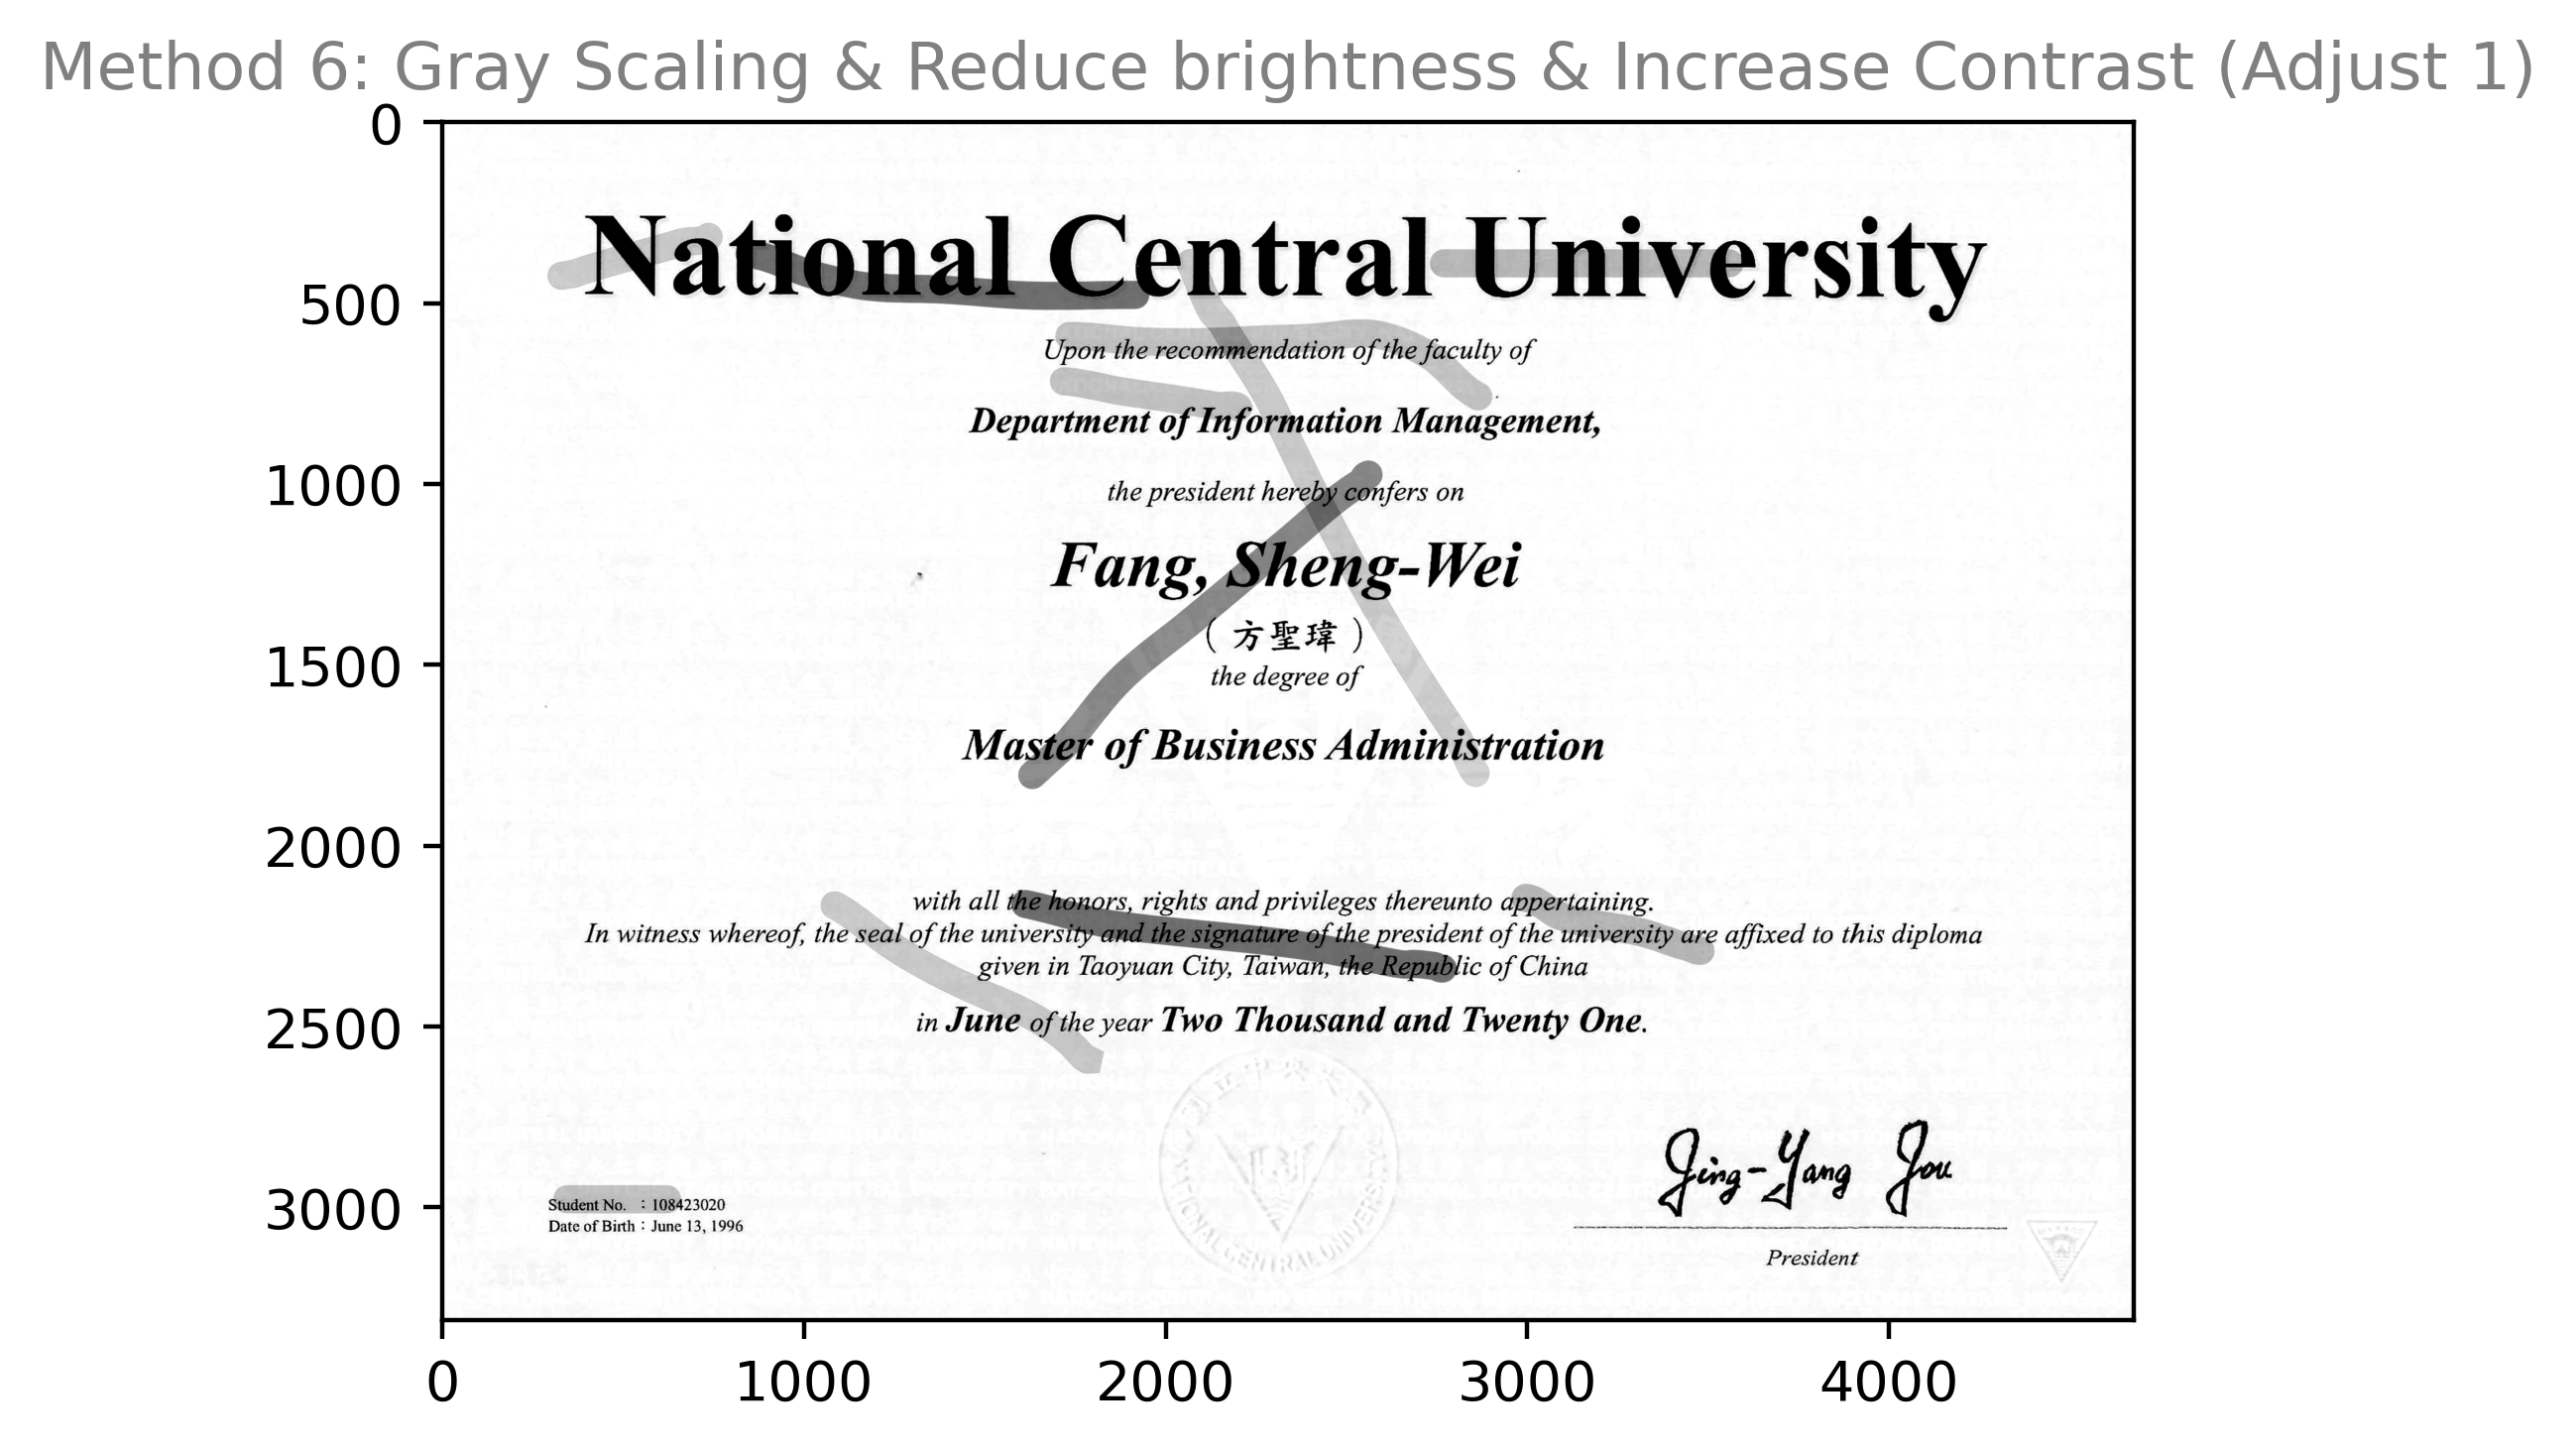

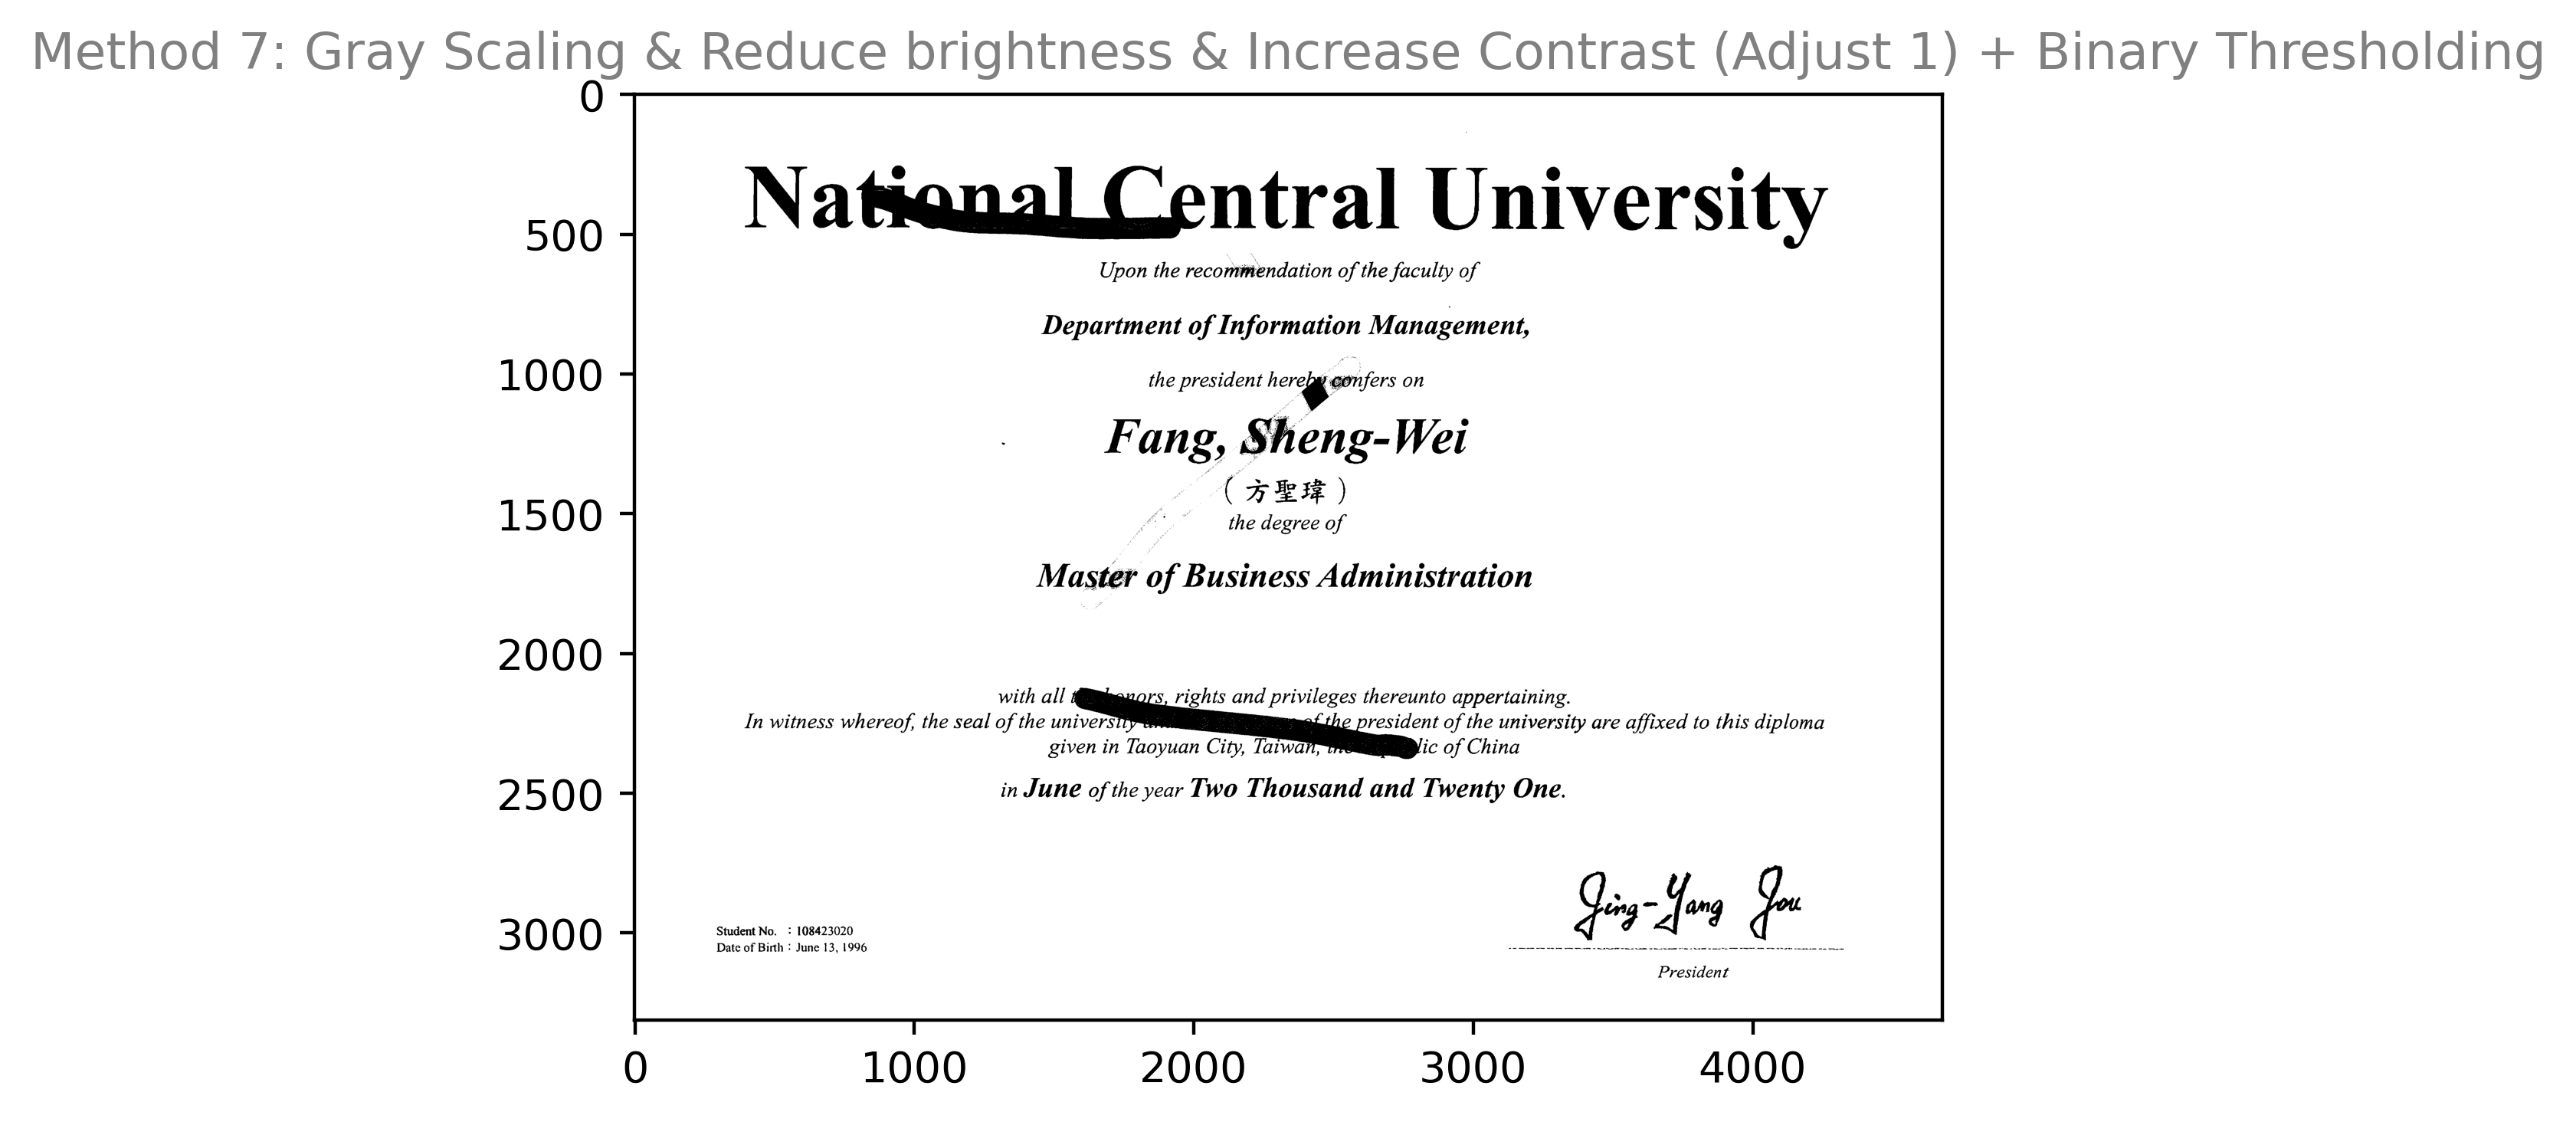

In [113]:
tmp_path = "Certificate of Degree_Marked\Page_1.jpg"
# tmp_path = "Transcripts\Page_1.jpg"

plt.figure(dpi=400)
plt.title('Method 0: Original Image', color= 'gray')
plt.imshow(get_cv2_img2(tmp_path,0), cmap="gray")
plt.figure(dpi=400)
plt.title('Method 1: Gray Scaling', color= 'gray')
plt.imshow(get_cv2_img2(tmp_path,1), cmap="gray")
plt.figure(dpi=400)
plt.title('Method 2: Gray Scaling & Binary Thresholding', color= 'gray')
plt.imshow(get_cv2_img2(tmp_path,2), cmap="gray")
plt.figure(dpi=400)
plt.title('Method 3: Gray Scaling & Inverse Binary Thresholding', color= 'gray')
plt.imshow(get_cv2_img2(tmp_path,3), cmap="gray")
plt.figure(dpi=400)
plt.title('Method 4: Gray Scaling & Increase brightness & Increase Contrast (Adjust 1)', color= 'gray')
plt.imshow(get_cv2_img2(tmp_path,4), cmap="gray")
plt.figure(dpi=400)
plt.title('Method 5: Gray Scaling & Increase brightness & Increase Contrast (Adjust 2)', color= 'gray')
plt.imshow(get_cv2_img2(tmp_path,5), cmap="gray")
plt.figure(dpi=400)
plt.title('Method 6: Gray Scaling & Reduce brightness & Increase Contrast (Adjust 1)', color= 'gray')
plt.imshow(get_cv2_img2(tmp_path,6), cmap="gray")
plt.figure(dpi=400)
plt.title('Method 7: Gray Scaling & Reduce brightness & Increase Contrast (Adjust 1) + Binary Thresholding', color= 'gray')
plt.imshow(get_cv2_img2(tmp_path,7), cmap="gray")

In [114]:
t = []
for i in range(0,7+1,1):
    t.append(text_recognition2(tmp_path,i))

In [115]:
# Methods Compared
# Method 0: Original Image
# Method 1: Gray Scaling
# Method 2: Gray Scaling & Binary Thresholding
# Method 3: Gray Scaling & Inverse Binary Thresholding
# Method 4: Gray Scaling & Increase brightness & Increase Contrast (Adjust 1)
# Method 5: Gray Scaling & Increase brightness & Increase Contrast (Adjust 2)
# Method 6: Gray Scaling & Reduce brightness & Increase Contrast (Adjust 1)
# Method 7: Gray Scaling & Reduce brightness & Increase Contrast (Adjust 1) + Binary Thresholding
for i, tt in enumerate(t):
    try:
#         print("Method "+str(i)+": ", np.round(np.mean(tt[(tt["width"]>200) & (tt["width"]<350)]["conf"]), 2))
#         print("Method "+str(i)+": ", np.round(np.mean(tt[(tt["width"]>100) & (tt["width"]<350)]["conf"]), 2))
        print("Method "+str(i)+": ", np.round(np.mean(tt["conf"]), 2))
    except:
        print("Method "+str(i)+": Not a good method for this image")

Method 0:  84.86
Method 1:  73.92
Method 2:  88.32
Method 3:  88.41
Method 4:  90.25
Method 5:  90.56
Method 6:  85.78
Method 7:  75.02


In [116]:
# Method 0: Original Image
print(text_recognition_data_to_txt1(t[0]))
t[0]

National Central-University

pon the recommendation of the faculty of

Department of Infe sation Management,

the president hereby confers on

Fang, Sheng-Wei

( FER )

the degree of

Master of Business Administration

with all s, rights and privileges thereunto ining.

the univers resident of the affixed to this diploma

iven in Taoyuan City, Taiwan, ic of China

e year Two Thousand and Twenty One.

23020 g ong 次 ang Gn

Date of Birth : June 13, 1996 I a a ee

President

In witness whereof, th


level  page_num  block_num  par_num  line_num  word_num  left   top  \
0       5         1          1        1         1         1   291   255   
1       5         1          1        1         1         2  1958   259   
2       5         1          3        1         1         1  1706   600   
3       5         1          3        1         1         2  1864   608   
4       5         1          3        1         1         3  1999   610   
5       5         1          3        1         1         4  2505   594   
6       5         1          3        1         1         5  2593   598   
7       5         1          3        1         1         6  2731   599   
8       5         1          3        1         1         7  2952   599   
9       5         1          3        1         2         1  1455   790   
10      5         1          3        1         2         2  1983   726   
11      5         1          3        1         2         3  2098   726   
12      5         1          3        1         2         4  2359   789   
13      5         1          3        1         2         5  2623   789   
14      5         1          3        1         3         1  1842   991   
15      5         1          3        1         3         2  1944   991   
16      5         1          3        1         3         3  2265   991   
17      5         1          3        1         3         4  2490   991   
18      5         1          3        1         3         5  2749  1011   
19      5         1          4        1         1         1  1680  1163   
20      5         1          4        1         1         2  2165  1159   
21      5         1          5        1         1         1  2108  1368   
22      5         1          5        1         1         2  2188  1370   
23      5         1          5        1         1         3  2476  1361   
24      5         1          5        1         2         1  2127  1502   
25      5         1          5        1         2         2  2242  1503   
26      5         1          5        1         2         3  2472  1502   
27      5         1          6        1         1         1  1435  1679   
28      5         1          6        1         1         2  1832  1677   
29      5         1          6        1         1         3  1959  1677   
30      5         1          6        1         1         4  2436  1677   
31      5         1          7        1         1         1  1301  2123   
32      5         1          7        1         1         2  1457  2123   
33      5         1          7        1         1         3  1862  2143   
34      5         1          7        1         1         4  1934  2123   
35      5         1          7        1         1         5  2139  2123   
36      5         1          7        1         1         6  2268  2123   
37      5         1          7        1         1         7  2608  2123   
38      5         1          7        1         1         8  3184  2129   
39      5         1          7        1         2         1  1376  2213   
40      5         1          7        1         2         2  1492  2217   
41      5         1          7        1         2         3  2624  2213   
42      5         1          7        1         2         4  2896  2213   
43      5         1          7        1         2         5  2978  2214   
44      5         1          7        1         2         6  3547  2215   
45      5         1          7        1         2         7  3789  2225   
46      5         1          7        1         2         8  3871  2214   
47      5         1          7        1         2         9  4008  2215   
48      5         1          7        1         3         1  1526  2307   
49      5         1          7        1         3         2  1676  2307   
50      5         1          7        1         3         3  1761  2304   
51      5         1          7        1         3         4  2048  2303   
52      5         1          

In [117]:
# Method 1: Gray Scaling
print(text_recognition_data_to_txt1(t[1]))
t[1]

_entral-University

Upon the recommendation of the faculty of

Department of Information Management,

the president aes on

Fang, Sheng-Wei

( FER )

the degree of

Master of Business Administration

with all th@thenors eee eG apr imae es thereunto appertaining.

In witness whereof, the seal of the universthyand Mei nature of th ie of the university are affixed to this diploma

given in estan Cin, Tora , the-Republic of China

in June of the year Two Thousand and Twenty One.

bY]

ma jan

Student No. : 108423020 g 2 ? Gu

Date of Birth : June 13, 1996 I i ee er ee 王

President


level  page_num  block_num  par_num  line_num  word_num  left   top  \
0        5         1          2        1         1         1  1779   259   
1        5         1          3        1         1         1  1667   601   
2        5         1          3        1         1         2  1859   599   
3        5         1          3        1         1         3  1972   599   
4        5         1          3        1         1         4  2518   599   
5        5         1          3        1         1         5  2600   599   
6        5         1          3        1         1         6  2700   599   
7        5         1          3        1         1         7  2952   599   
8        5         1          3        1         2         1  1455   790   
9        5         1          3        1         2         2  1983   787   
10       5         1          3        1         2         3  2085   787   
11       5         1          3        1         2         4  2623   754   
12       5         1          3        1         3         1  1842   991   
13       5         1          3        1         3         2  1944   991   
14       5         1          3        1         3         3  2265   991   
15       5         1          3        1         3         4  2749  1011   
16       5         1          3        1         4         1  1680  1163   
17       5         1          3        1         4         2  2165  1159   
18       5         1          4        1         1         1  2108  1368   
19       5         1          4        1         1         2  2188  1370   
20       5         1          4        1         1         3  2478  1360   
21       5         1          4        1         2         1  2127  1502   
22       5         1          4        1         2         2  2242  1503   
23       5         1          4        1         2         3  2472  1502   
24       5         1          5        1         1         1  1435  1679   
25       5         1          5        1         1         2  1832  1677   
26       5         1          5        1         1         3  1959  1677   
27       5         1          5        1         1         4  2436  1677   
28       5         1          7        1         1         1  1301  2123   
29       5         1          7        1         1         2  1457  2123   
30       5         1          7        1         1         3  1567  2126   
31       5         1          7        1         1         4  1933  2123   
32       5         1          7        1         1         5  2137  2123   
33       5         1          7        1         1         6  2218  2143   
34       5         1          7        1         1         7  2355  2123   
35       5         1          7        1         1         8  2530  2143   
36       5         1          7        1         1         9  2608  2123   
37       5         1          7        1         1        10  2927  2129   
38       5         1          7        1         2         1   394  2215   
39       5         1          7        1         2         2   484  2219   
40       5         1          7        1         2         3   736  2213   
41       5         1          7        1         2         4  1030  2213   
42       5         1          7        1         2         5  1141  2213   
43       5         1          7        1         2         6  1293  2213   
44       5         1          7        1         2         7  1376  2213   
45       5         1          7        1         2         8  1492  2200   
46       5         1          7        1         2         9  1961  2211   
47       5         1          7        1         2        10  2168  2230   
48       5         1          7        1         2        11  2394  2236   
49       5         1          7        1         2        12  2468  2239   
50       5         1          7        1         2        13  2538  2213   
51       5         1          7        1         2   

In [118]:
# Method 2: Gray Scaling & Binary Thresholding
print(text_recognition_data_to_txt1(t[2]))
t[2]

National Central University

Upon the recommendation of the faculty of

Department of Information Management,

the president hereby confers on

Fang, Sheng-Wei

( EF )

the degree of

Master of Business Administration

with all the honors, rights and privileges thereunto appertaining.

In witness whereof, the seal of the university and the signature of the president of the university are affixed to this diploma

given in Taoyuan City, Taiwan, the Republic of China

in June of the year Two Thousand and Twenty One.

a

cng fam

Student No. : 108423020 g 2 ? Go

Date of Birth : June 13, 1996 ve cee ee eee 和

President


level  page_num  block_num  par_num  line_num  word_num  left   top  \
0        5         1          1        1         1         1   395   255   
1        5         1          1        1         1         2  1680   256   
2        5         1          1        1         1         3  2830   260   
3        5         1          2        1         1         1  1668   601   
4        5         1          2        1         1         2  1859   600   
5        5         1          2        1         1         3  1973   599   
6        5         1          2        1         1         4  2518   599   
7        5         1          2        1         1         5  2600   599   
8        5         1          2        1         1         6  2700   600   
9        5         1          2        1         1         7  2952   600   
10       5         1          3        1         1         1  1455   790   
11       5         1          3        1         1         2  1983   787   
12       5         1          3        1         1         3  2085   788   
13       5         1          3        1         1         4  2624   754   
14       5         1          4        1         1         1  1842   992   
15       5         1          4        1         1         2  1945   991   
16       5         1          4        1         1         3  2265   991   
17       5         1          4        1         1         4  2494   991   
18       5         1          4        1         1         5  2750  1011   
19       5         1          5        1         1         1  1680  1163   
20       5         1          5        1         1         2  2166  1159   
21       5         1          6        1         1         1  2113  1369   
22       5         1          6        1         1         2  2188  1376   
23       5         1          6        1         1         3  2518  1370   
24       5         1          6        1         2         1  2127  1503   
25       5         1          6        1         2         2  2243  1503   
26       5         1          6        1         2         3  2472  1502   
27       5         1          7        1         1         1  1435  1680   
28       5         1          7        1         1         2  1832  1677   
29       5         1          7        1         1         3  1960  1678   
30       5         1          7        1         1         4  2436  1677   
31       5         1          8        1         1         1  1302  2123   
32       5         1          8        1         1         2  1457  2123   
33       5         1          8        1         1         3  1562  2123   
34       5         1          8        1         1         4  1675  2123   
35       5         1          8        1         1         5  1935  2123   
36       5         1          8        1         1         6  2139  2123   
37       5         1          8        1         1         7  2268  2123   
38       5         1          8        1         1         8  2608  2123   
39       5         1          8        1         1         9  2927  2129   
40       5         1          8        1         2         1   394  2216   
41       5         1          8        1         2         2   484  2219   
42       5         1          8        1         2         3   737  2213   
43       5         1          8        1         2         4  1031  2213   
44       5         1          8        1         2         5  1142  2213   
45       5         1          8        1         2         6  1293  2213   
46       5         1          8        1         2         7  1377  2213   
47       5         1          8        1         2         8  1492  2217   
48       5         1          8        1         2         9  1822  2212   
49       5         1          8        1         2        10  1960  2212   
50       5         1          8        1         2        11  2070  2217   
51       5         1          8        1         2   

In [119]:
# Method 3: Gray Scaling & Inverse Binary Thresholding
print(text_recognition_data_to_txt1(t[3]))
t[3]

National Central University

Upon the recommendation of the faculty of

Department of Information Management,

the president hereby confers on

Fang, Sheng-Wei

( 方 聖 瑋 )

the degree of

Master of Business Administration

with all the honors, rights and privileges thereunto appertaining.

In witness whereof, the seal of the university and the signature of the president of the university are affixed to this diploma

given in Taoyuan City, Taiwan, the Republic of China

in June of the year Two Thousand and Twenty One.

a

cng fom

Student No. : 108423020 g 2 ? Gu

Date of Birth : June 13, 1996 nee cane seen cae

President


level  page_num  block_num  par_num  line_num  word_num  left   top  \
0        5         1          1        1         1         1   395   255   
1        5         1          1        1         1         2  1680   256   
2        5         1          1        1         1         3  2830   260   
3        5         1          2        1         1         1  1668   601   
4        5         1          2        1         1         2  1859   600   
5        5         1          2        1         1         3  1973   599   
6        5         1          2        1         1         4  2518   599   
7        5         1          2        1         1         5  2600   599   
8        5         1          2        1         1         6  2700   600   
9        5         1          2        1         1         7  2952   600   
10       5         1          3        1         1         1  1455   790   
11       5         1          3        1         1         2  1983   787   
12       5         1          3        1         1         3  2085   788   
13       5         1          3        1         1         4  2624   754   
14       5         1          4        1         1         1  1842   992   
15       5         1          4        1         1         2  1945   991   
16       5         1          4        1         1         3  2265   991   
17       5         1          4        1         1         4  2494   991   
18       5         1          4        1         1         5  2750  1011   
19       5         1          5        1         1         1  1680  1163   
20       5         1          5        1         1         2  2166  1159   
21       5         1          6        1         1         1  2113  1369   
22       5         1          6        1         1         2  2212  1377   
23       5         1          6        1         1         3  2326  1379   
24       5         1          6        1         1         4  2429  1376   
25       5         1          6        1         1         5  2518  1370   
26       5         1          6        1         2         1  2127  1503   
27       5         1          6        1         2         2  2243  1503   
28       5         1          6        1         2         3  2472  1502   
29       5         1          7        1         1         1  1435  1680   
30       5         1          7        1         1         2  1832  1677   
31       5         1          7        1         1         3  1960  1678   
32       5         1          7        1         1         4  2436  1677   
33       5         1          8        1         1         1  1302  2123   
34       5         1          8        1         1         2  1457  2123   
35       5         1          8        1         1         3  1562  2123   
36       5         1          8        1         1         4  1675  2123   
37       5         1          8        1         1         5  1935  2123   
38       5         1          8        1         1         6  2139  2123   
39       5         1          8        1         1         7  2268  2123   
40       5         1          8        1         1         8  2608  2123   
41       5         1          8        1         1         9  2927  2129   
42       5         1          8        1         2         1   394  2216   
43       5         1          8        1         2         2   484  2219   
44       5         1          8        1         2         3   737  2213   
45       5         1          8        1         2         4  1031  2213   
46       5         1          8        1         2         5  1142  2213   
47       5         1          8        1         2         6  1293  2213   
48       5         1          8        1         2         7  1377  2213   
49       5         1          8        1         2         8  1492  2217   
50       5         1          8        1         2         9  1822  2212   
51       5         1          8        1         2   

In [120]:
# Method 4: Gray Scaling & Increase brightness & Increase Contrast (Adjust 1)
print(text_recognition_data_to_txt1(t[4]))
t[4]

National Central University

Upon the recommendation of the faculty of

Department of Information Management,

the president hereby confers on

Fang, Sheng-Wei

( FER )

the degree of

Master of Business Administration

with all thehenors, rights and privileges thereunto appertaining.

In witness whereof, the seal of the university and the signature of the president of the university are affixed to this diploma

given in Taoyuan City, Taiwan, the Republic of China

in June of the year Two Thousand and Twenty One.

全

“9 ~ Yang

Student No. +: 108423020

Date of Birth : June 13, 1996 一 一 一 一 一 一 ~~

President


level  page_num  block_num  par_num  line_num  word_num  left   top  \
0        5         1          1        1         1         1   396   256   
1        5         1          1        1         1         2  1680   257   
2        5         1          1        1         1         3  2830   260   
3        5         1          2        1         1         1  1668   601   
4        5         1          2        1         1         2  1860   600   
5        5         1          2        1         1         3  1973   599   
6        5         1          2        1         1         4  2519   599   
7        5         1          2        1         1         5  2600   599   
8        5         1          2        1         1         6  2701   600   
9        5         1          2        1         1         7  2952   600   
10       5         1          3        1         1         1  1456   791   
11       5         1          3        1         1         2  1984   788   
12       5         1          3        1         1         3  2085   788   
13       5         1          3        1         1         4  2624   759   
14       5         1          4        1         1         1  1842   992   
15       5         1          4        1         1         2  1945   992   
16       5         1          4        1         1         3  2266   991   
17       5         1          4        1         1         4  2494   992   
18       5         1          4        1         1         5  2750  1011   
19       5         1          5        1         1         1  1680  1163   
20       5         1          5        1         1         2  2167  1159   
21       5         1          5        1         2         1  2113  1370   
22       5         1          5        1         2         2  2189  1376   
23       5         1          5        1         2         3  2519  1371   
24       5         1          6        1         1         1  2128  1503   
25       5         1          6        1         1         2  2243  1503   
26       5         1          6        1         1         3  2472  1503   
27       5         1          7        1         1         1  1435  1680   
28       5         1          7        1         1         2  1832  1678   
29       5         1          7        1         1         3  1960  1678   
30       5         1          7        1         1         4  2436  1678   
31       5         1          8        1         1         1  1302  2124   
32       5         1          8        1         1         2  1457  2123   
33       5         1          8        1         1         3  1562  2123   
34       5         1          8        1         1         4  1935  2123   
35       5         1          8        1         1         5  2139  2123   
36       5         1          8        1         1         6  2269  2123   
37       5         1          8        1         1         7  2608  2124   
38       5         1          8        1         1         8  2928  2130   
39       5         1          8        1         2         1   394  2216   
40       5         1          8        1         2         2   485  2219   
41       5         1          8        1         2         3   738  2214   
42       5         1          8        1         2         4  1031  2214   
43       5         1          8        1         2         5  1142  2214   
44       5         1          8        1         2         6  1293  2213   
45       5         1          8        1         2         7  1377  2213   
46       5         1          8        1         2         8  1492  2217   
47       5         1          8        1         2         9  1822  2212   
48       5         1          8        1         2        10  1960  2213   
49       5         1          8        1         2        11  2071  2217   
50       5         1          8        1         2        12  2389  2213   
51       5         1          8        1         2   

In [121]:
# Method 5: Gray Scaling & Increase brightness & Increase Contrast (Adjust 2)
print(text_recognition_data_to_txt1(t[5]))
t[5]

National Central University

Upon the recommendation of the faculty of

Department of Information Management,

the president hereby confers on

Fang, Sheng-Wei

( 方 聖 瑋

the degree of

Master of Business Administration

with all thehenors, rights and privileges thereunto appertaining.

In witness whereof, the seal of the university and the signaturevof.the president of the university are affixed to this diploma

given in Taoyuan City, Taiwan, the Republic of China

in June of the year Two Thousand and Twenty One.

全

Student No. :108423020

Date of Birth : June 13, 1996 一 一 一 一 一 一 一 一 一 一 一 一

President


level  page_num  block_num  par_num  line_num  word_num  left   top  \
0        5         1          1        1         1         1   395   256   
1        5         1          1        1         1         2  1680   256   
2        5         1          1        1         1         3  2830   260   
3        5         1          2        1         1         1  1668   601   
4        5         1          2        1         1         2  1859   600   
5        5         1          2        1         1         3  1973   599   
6        5         1          2        1         1         4  2519   599   
7        5         1          2        1         1         5  2600   599   
8        5         1          2        1         1         6  2701   600   
9        5         1          2        1         1         7  2952   600   
10       5         1          3        1         1         1  1456   790   
11       5         1          3        1         1         2  1983   788   
12       5         1          3        1         1         3  2085   788   
13       5         1          3        1         1         4  2624   755   
14       5         1          4        1         1         1  1842   992   
15       5         1          4        1         1         2  1945   992   
16       5         1          4        1         1         3  2266   991   
17       5         1          4        1         1         4  2494   992   
18       5         1          4        1         1         5  2750  1011   
19       5         1          5        1         1         1  1680  1163   
20       5         1          5        1         1         2  2167  1159   
21       5         1          5        1         2         1  2113  1369   
22       5         1          5        1         2         2  2214  1377   
23       5         1          5        1         2         3  2327  1379   
24       5         1          5        1         2         4  2424  1376   
25       5         1          6        1         1         1  2128  1503   
26       5         1          6        1         1         2  2243  1503   
27       5         1          6        1         1         3  2472  1503   
28       5         1          7        1         1         1  1435  1680   
29       5         1          7        1         1         2  1832  1678   
30       5         1          7        1         1         3  1960  1678   
31       5         1          7        1         1         4  2436  1678   
32       5         1          8        1         1         1  1302  2123   
33       5         1          8        1         1         2  1457  2123   
34       5         1          8        1         1         3  1562  2123   
35       5         1          8        1         1         4  1935  2123   
36       5         1          8        1         1         5  2139  2123   
37       5         1          8        1         1         6  2269  2123   
38       5         1          8        1         1         7  2608  2123   
39       5         1          8        1         1         8  2927  2130   
40       5         1          8        1         2         1   394  2216   
41       5         1          8        1         2         2   485  2219   
42       5         1          8        1         2         3   737  2214   
43       5         1          8        1         2         4  1031  2214   
44       5         1          8        1         2         5  1142  2213   
45       5         1          8        1         2         6  1293  2213   
46       5         1          8        1         2         7  1377  2213   
47       5         1          8        1         2         8  1492  2217   
48       5         1          8        1         2         9  1822  2212   
49       5         1          8        1         2        10  1960  2213   
50       5         1          8        1         2        11  2071  2213   
51       5         1          8        1         2   

In [122]:
# Method 6: Gray Scaling & Reduce brightness & Increase Contrast (Adjust 1)
print(text_recognition_data_to_txt1(t[6]))
t[6]

National Central-University

Upon the recommendation of the faculty of

Department of Information Management,

with all Ss, rights and privileges thereunto appertaining.

In witness whereof, the seal of the univers resident of the universityare affixed to this diploma

given in Taoyuan City, Taiwan, ic of China

in June of the year Two Thousand and Twenty One.

A]

7); 一 fan

Student No. <: 108423020 g a 9 Gu

Date of Birth : June 13, 1996 ie

President


level  page_num  block_num  par_num  line_num  word_num  left   top  \
0       5         1          1        1         1         1   395   216   
1       5         1          1        1         1         2  1759   259   
2       5         1          2        1         1         1  1667   601   
3       5         1          2        1         1         2  1858   599   
4       5         1          2        1         1         3  1972   562   
5       5         1          2        1         1         4  2517   599   
6       5         1          2        1         1         5  2600   598   
7       5         1          2        1         1         6  2699   599   
8       5         1          2        1         1         7  2951   599   
9       5         1          3        1         1         1  1455   790   
10      5         1          3        1         1         2  1983   787   
11      5         1          3        1         1         3  2085   787   
12      5         1          3        1         1         4  2622   753   
13      5         1          5        1         1         1  1301  2123   
14      5         1          5        1         1         2  1457  2123   
15      5         1          5        1         1         3  1862  2143   
16      5         1          5        1         1         4  1934  2123   
17      5         1          5        1         1         5  2139  2122   
18      5         1          5        1         1         6  2267  2123   
19      5         1          5        1         1         7  2608  2123   
20      5         1          5        1         1         8  2926  2129   
21      5         1          5        1         2         1   393  2215   
22      5         1          5        1         2         2   484  2219   
23      5         1          5        1         2         3   736  2213   
24      5         1          5        1         2         4  1030  2213   
25      5         1          5        1         2         5  1141  2213   
26      5         1          5        1         2         6  1293  2213   
27      5         1          5        1         2         7  1376  2213   
28      5         1          5        1         2         8  1491  2217   
29      5         1          5        1         2         9  2624  2213   
30      5         1          5        1         2        10  2896  2213   
31      5         1          5        1         2        11  2978  2213   
32      5         1          5        1         2        12  3093  2219   
33      5         1          5        1         2        13  3546  2215   
34      5         1          5        1         2        14  3789  2224   
35      5         1          5        1         2        15  3870  2214   
36      5         1          5        1         2        16  4008  2215   
37      5         1          5        1         3         1  1479  2307   
38      5         1          5        1         3         2  1675  2307   
39      5         1          5        1         3         3  1760  2304   
40      5         1          5        1         3         4  2048  2303   
41      5         1          5        1         3         5  2214  2303   
42      5         1          5        1         3         6  2820  2307   
43      5         1          5        1         3         7  2895  2303   
44      5         1          5        1         3         8  2980  2303   
45      5         1          6        1         1         1  1312  2463   
46      5         1          6        1         1         2  1391  2446   
47      5         1          6        1         1         3  1625  2458   
48      5         1          6        1         1         4  1708  2458   
49      5         1          6        1         1         5  1815  2478   
50      5         1          6        1         1         6  2043  2466   
51      5         1          6        1         1         7  2191  2443   
52      5         1          

In [123]:
# Method 7: Gray Scaling & Reduce brightness & Increase Contrast (Adjust 1) + Binary Thresholding
print(text_recognition_data_to_txt1(t[7]))
t[7]

NattenalL Central University

Upon the recomimendation of the faculty of

Department of Information Management,

the president here y.gonfers on

Fan co Sh 1eng-Wei

(FE)

the net of

Master of Business Administration

with all t BOS ee and privileges thereunto appertaining.

In witness whereof, the seal of the universt™ 國 說 了 和 president of the university are affixed to this diploma

a

ing fam

Student No. : 108423020 g 2 ? Gn

Date of Birth : June 13, 1996 ee ee ee

President


level  page_num  block_num  par_num  line_num  word_num  left   top  \
0       5         1          1        1         1         1   395   211   
1       5         1          1        1         1         2  1721   211   
2       5         1          1        1         1         3  2829   259   
3       5         1          2        1         1         1  1667   601   
4       5         1          2        1         1         2  1859   599   
5       5         1          2        1         1         3  1972   566   
6       5         1          2        1         1         4  2518   599   
7       5         1          2        1         1         5  2600   599   
8       5         1          2        1         1         6  2700   599   
9       5         1          2        1         1         7  2952   599   
10      5         1          2        1         2         1  1455   790   
11      5         1          2        1         2         2  1983   787   
12      5         1          2        1         2         3  2085   787   
13      5         1          2        1         2         4  2623   789   
14      5         1          3        1         1         1  1841   991   
15      5         1          3        1         1         2  1944   991   
16      5         1          3        1         1         3  2265   991   
17      5         1          3        1         1         4  2454   986   
18      5         1          3        1         1         5  2749  1011   
19      5         1          6        1         1         1  1680  1163   
20      5         1          6        1         1         2  1929  1200   
21      5         1          6        1         1         3  2185  1140   
22      5         1          6        1         1         4  2332  1110   
23      5         1          6        1         2         1  2023  1337   
24      5         1          6        1         3         1  2127  1502   
25      5         1          6        1         3         2  2242  1387   
26      5         1          6        1         3         3  2472  1502   
27      5         1          7        1         1         1  1435  1660   
28      5         1          7        1         1         2  1832  1677   
29      5         1          7        1         1         3  1959  1677   
30      5         1          7        1         1         4  2436  1677   
31      5         1          9        1         1         1  1301  2123   
32      5         1          9        1         1         2  1457  2123   
33      5         1          9        1         1         3  1567  2151   
34      5         1          9        1         1         4  1730  2143   
35      5         1          9        1         1         5  1934  2123   
36      5         1          9        1         1         6  2139  2123   
37      5         1          9        1         1         7  2236  2123   
38      5         1          9        1         1         8  2608  2123   
39      5         1          9        1         1         9  2927  2129   
40      5         1          9        1         2         1   393  2215   
41      5         1          9        1         2         2   484  2219   
42      5         1          9        1         2         3   736  2213   
43      5         1          9        1         2         4  1030  2213   
44      5         1          9        1         2         5  1141  2213   
45      5         1          9        1         2         6  1293  2213   
46      5         1          9        1         2         7  1376  2213   
47      5         1          9        1         2         8  1491  2217   
48      5         1          9        1         2         9  2249  2251   
49      5         1          9        1         2        10  2346  2254   
50      5         1          9        1         2        11  2403  2236   
51      5         1          9        1         2        12  2500  2236   
52      5         1          

In [124]:
# # for i in [5]:
# for i in range(1, 15+1):
#     if not os.path.isdir('kickoff_'+str(i)+"_Edit/JPG/Converted2_3"):
#         os.mkdir('kickoff_'+str(i)+"_Edit/JPG/Converted2_3")
#     print("Image recognition "+str(i)+"......")
    
#     with pd.ExcelWriter('kickoff_'+str(i)+"_Edit/JPG/Converted2_3/Kickoff_"+str(i)+".xlsx") as writer:
        
#         for image_path in glob('kickoff_'+str(i)+"_Edit/JPG/Unmarked/*.jpg"):
#             image_recog_df_list = [text_recognition_data_transform1(text_recognition2(image_path, 0)), 
#                                    text_recognition_data_transform1(text_recognition2(image_path, 1)), 
#                                    text_recognition_data_transform1(text_recognition2(image_path, 6)), 
#                                    text_recognition_data_transform1(text_recognition2(image_path, 7))]
#             image_recog_df = image_recognition_choose_best1(image_recog_df_list)
#             with open('kickoff_'+str(i)+"_Edit/JPG/Converted2_3/"+image_path.split("\\")[-1].split(".")[0]+".txt", "w", encoding='UTF-8') as text_file:
#                 text_file.write(image_recognition_data_transform_text1(image_recog_df))
#             image_recog_df.to_excel(writer, sheet_name=image_path.split("\\")[-1].split(".")[0], index=False)
        
#         for image_path in glob('kickoff_'+str(i)+"_Edit/JPG/New/*.jpg"):
#             image_recog_df_list = [text_recognition_data_transform1(text_recognition2(image_path, 0)), 
#                                    text_recognition_data_transform1(text_recognition2(image_path, 1)), 
#                                    text_recognition_data_transform1(text_recognition2(image_path, 2)), 
#                                    text_recognition_data_transform1(text_recognition2(image_path, 3)), 
#                                    text_recognition_data_transform1(text_recognition2(image_path, 4)), 
#                                    text_recognition_data_transform1(text_recognition2(image_path, 5)), 
#                                    text_recognition_data_transform1(text_recognition2(image_path, 6)), 
#                                    text_recognition_data_transform1(text_recognition2(image_path, 7))]
#             image_recog_df = image_recognition_choose_best1(image_recog_df_list)
#             with open('kickoff_'+str(i)+"_Edit/JPG/Converted2_3/"+image_path.split("\\")[-1].split(".")[0]+".txt", "w", encoding='UTF-8') as text_file:
#                 text_file.write(image_recognition_data_transform_text1(image_recog_df))
#             image_recog_df.to_excel(writer, sheet_name=image_path.split("\\")[-1].split(".")[0], index=False)
        
#         for image_path in glob('kickoff_'+str(i)+"_Edit/JPG/Marked/*.jpg"):
#             image_recog_df_list = [text_recognition_data_transform1(text_recognition2(image_path, 2)), 
#                                    text_recognition_data_transform1(text_recognition2(image_path, 3)), 
#                                    text_recognition_data_transform1(text_recognition2(image_path, 4)), 
#                                    text_recognition_data_transform1(text_recognition2(image_path, 5)), 
#                                    text_recognition_data_transform1(text_recognition2(image_path, 6)), 
#                                    text_recognition_data_transform1(text_recognition2(image_path, 7))]
#             image_recog_df = image_recognition_choose_best1(image_recog_df_list)
#             with open('kickoff_'+str(i)+"_Edit/JPG/Converted2_3/"+image_path.split("\\")[-1].split(".")[0]+".txt", "w", encoding='UTF-8') as text_file:
#                 text_file.write(image_recognition_data_transform_text1(image_recog_df))
#             image_recog_df.to_excel(writer, sheet_name=image_path.split("\\")[-1].split(".")[0], index=False)
        
        
#     print("Image recognition "+str(i)+" Done!")

In [ ]:
# temp_string = ""
# for i in set(t[7]["block_num"]):
#     for j in set(t[7]["line_num"]):
#         temp_string += t[7][(t[7]["block_num"]==i) & (t[7]["line_num"]==j)]["text"].str.cat(sep=' ') + "\n"
# print(temp_string)

In [122]:
# 1.	level = 1/2/3/4/5，用於標注當前項的層級。
# 2.	page_num, level = 1;用於標注當前項所屬頁面。一般情況下，單張圖片的內容均會被分在同一個頁，且在tsv檔中只有第一行的level為1，當level=1時，left=0, top=0, width和height分別是圖片的實際寬度和高度。
# 3.	block_num, level = 2; Tesseract會將圖像分割為多個不同的block，block會出現1，2，3……等等值
# 4.	par_num, level = 3; 從Tessract的相關文檔來看，該參數應該是當前圖像中文字的段落分類，level=1/2/3時，該值為0；其他情況為1。
# 5.	line_num, level = 4; 一般均為1。
# 6.	word_num, level = 5;在同一行[line_num]中出現的單詞序號。
# 7.	left/top/width/height：當前項所在長方形區域的左上角，寬度，高度。
# 8.	conf，當前檢測字元的置信度，表示項無文字，值為-1；若Tesseract認為當前區域有文字，則其值得範圍為0~100。

# References

1. https://stackoverflow.com/questions/71442585/adjusting-pytesseract-parameters
2. https://ithelp.ithome.com.tw/articles/10210214
3. https://python-bloggers.com/2022/05/extract-text-from-image-using-python/
4. (tabula) https://aegis4048.github.io/parse-pdf-files-while-retaining-structure-with-tabula-py
5. https://stackoverflow.com/questions/34837707/how-to-extract-text-from-a-pdf-file
6. https://www.geeksforgeeks.org/extract-text-from-pdf-file-using-python/
7. https://towardsdatascience.com/how-to-extract-text-from-pdf-245482a96de7
8. https://towardsdatascience.com/extracting-text-from-scanned-pdf-using-pytesseract-open-cv-cd670ee38052
9. https://betterprogramming.pub/efficiently-convert-pdf-to-png-or-jpeg-images-in-python-50c5ce224c20
10. https://pdf.wondershare.com/pdf-knowledge/pdf-to-png-python.html
11. https://github.com/tesseract-ocr/tesseract
12. https://vimsky.com/zh-tw/examples/usage/python-opencv-cv2-cvtcolor-method.html
13. https://pdf2image.readthedocs.io/en/latest/reference.html
14. (Need Java) https://products.aspose.com/cells/python-java/conversion/jpg-to-excel/
15. https://ithelp.ithome.com.tw/articles/10245342
16. https://blog.csdn.net/hxxjxw/article/details/117961339
17. https://dotblogs.com.tw/CYLcode/2020/03/12/111420
18. https://ithelp.ithome.com.tw/users/20120424/ironman/3642
19. https://blog.gtwang.org/programming/opencv-drawing-functions-tutorial/
20. https://splunktool.com/pandas-dataframe-select-multiple-discontinuous-columnsslices
21. https://ithelp.ithome.com.tw/articles/10240032
22. https://ithelp.ithome.com.tw/articles/10246927
23. https://steam.oxxostudio.tw/category/python/basic/try-except.html
24. https://openhome.cc/zh-tw/python/exception/try-except/
25. https://pypi.org/project/pytesseract/
26. https://lufor129.medium.com/opencv圖片處理整理-緩慢更新-b45e248d14bb
27. https://medium.com/jimmy-wang/opencv-基礎教學筆記-with-python-d780f571a57a
28. https://livezingy.com/pytesseract-image_to_data_locate_text/
29. https://pypi.org/project/pytesseract/
30. https://weirenxue.github.io/2021/06/12/python_cp950_codec_cant_encode/
31. https://stackoverflow.com/questions/5214578/print-string-to-text-file
32. https://stackoverflow.com/questions/33279940/how-to-combine-multiple-rows-of-strings-into-one-using-pandas
33. https://d246810g2000.medium.com/文字辨識方法統整-1e3d3ba5fe54
34. 
35. 

# XXX